# DMA Map Only

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load GeoJSON
gdf = gpd.read_file('/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/DMA_data/nielsen-dma-master/nielsen_dma.json')

# Plot and save
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, edgecolor='black', color='lightblue')
ax.set_xlim(-130, -65)
ax.set_ylim(23, 50)
ax.set_title("Nielsen DMAs - USA Only")
plt.axis('off')
plt.savefig('/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/DMA_data/nielsen-dma-master/nielsen_static_map.png', bbox_inches='tight', dpi=300)


# NY DMA

No handles with labels found to put in legend.


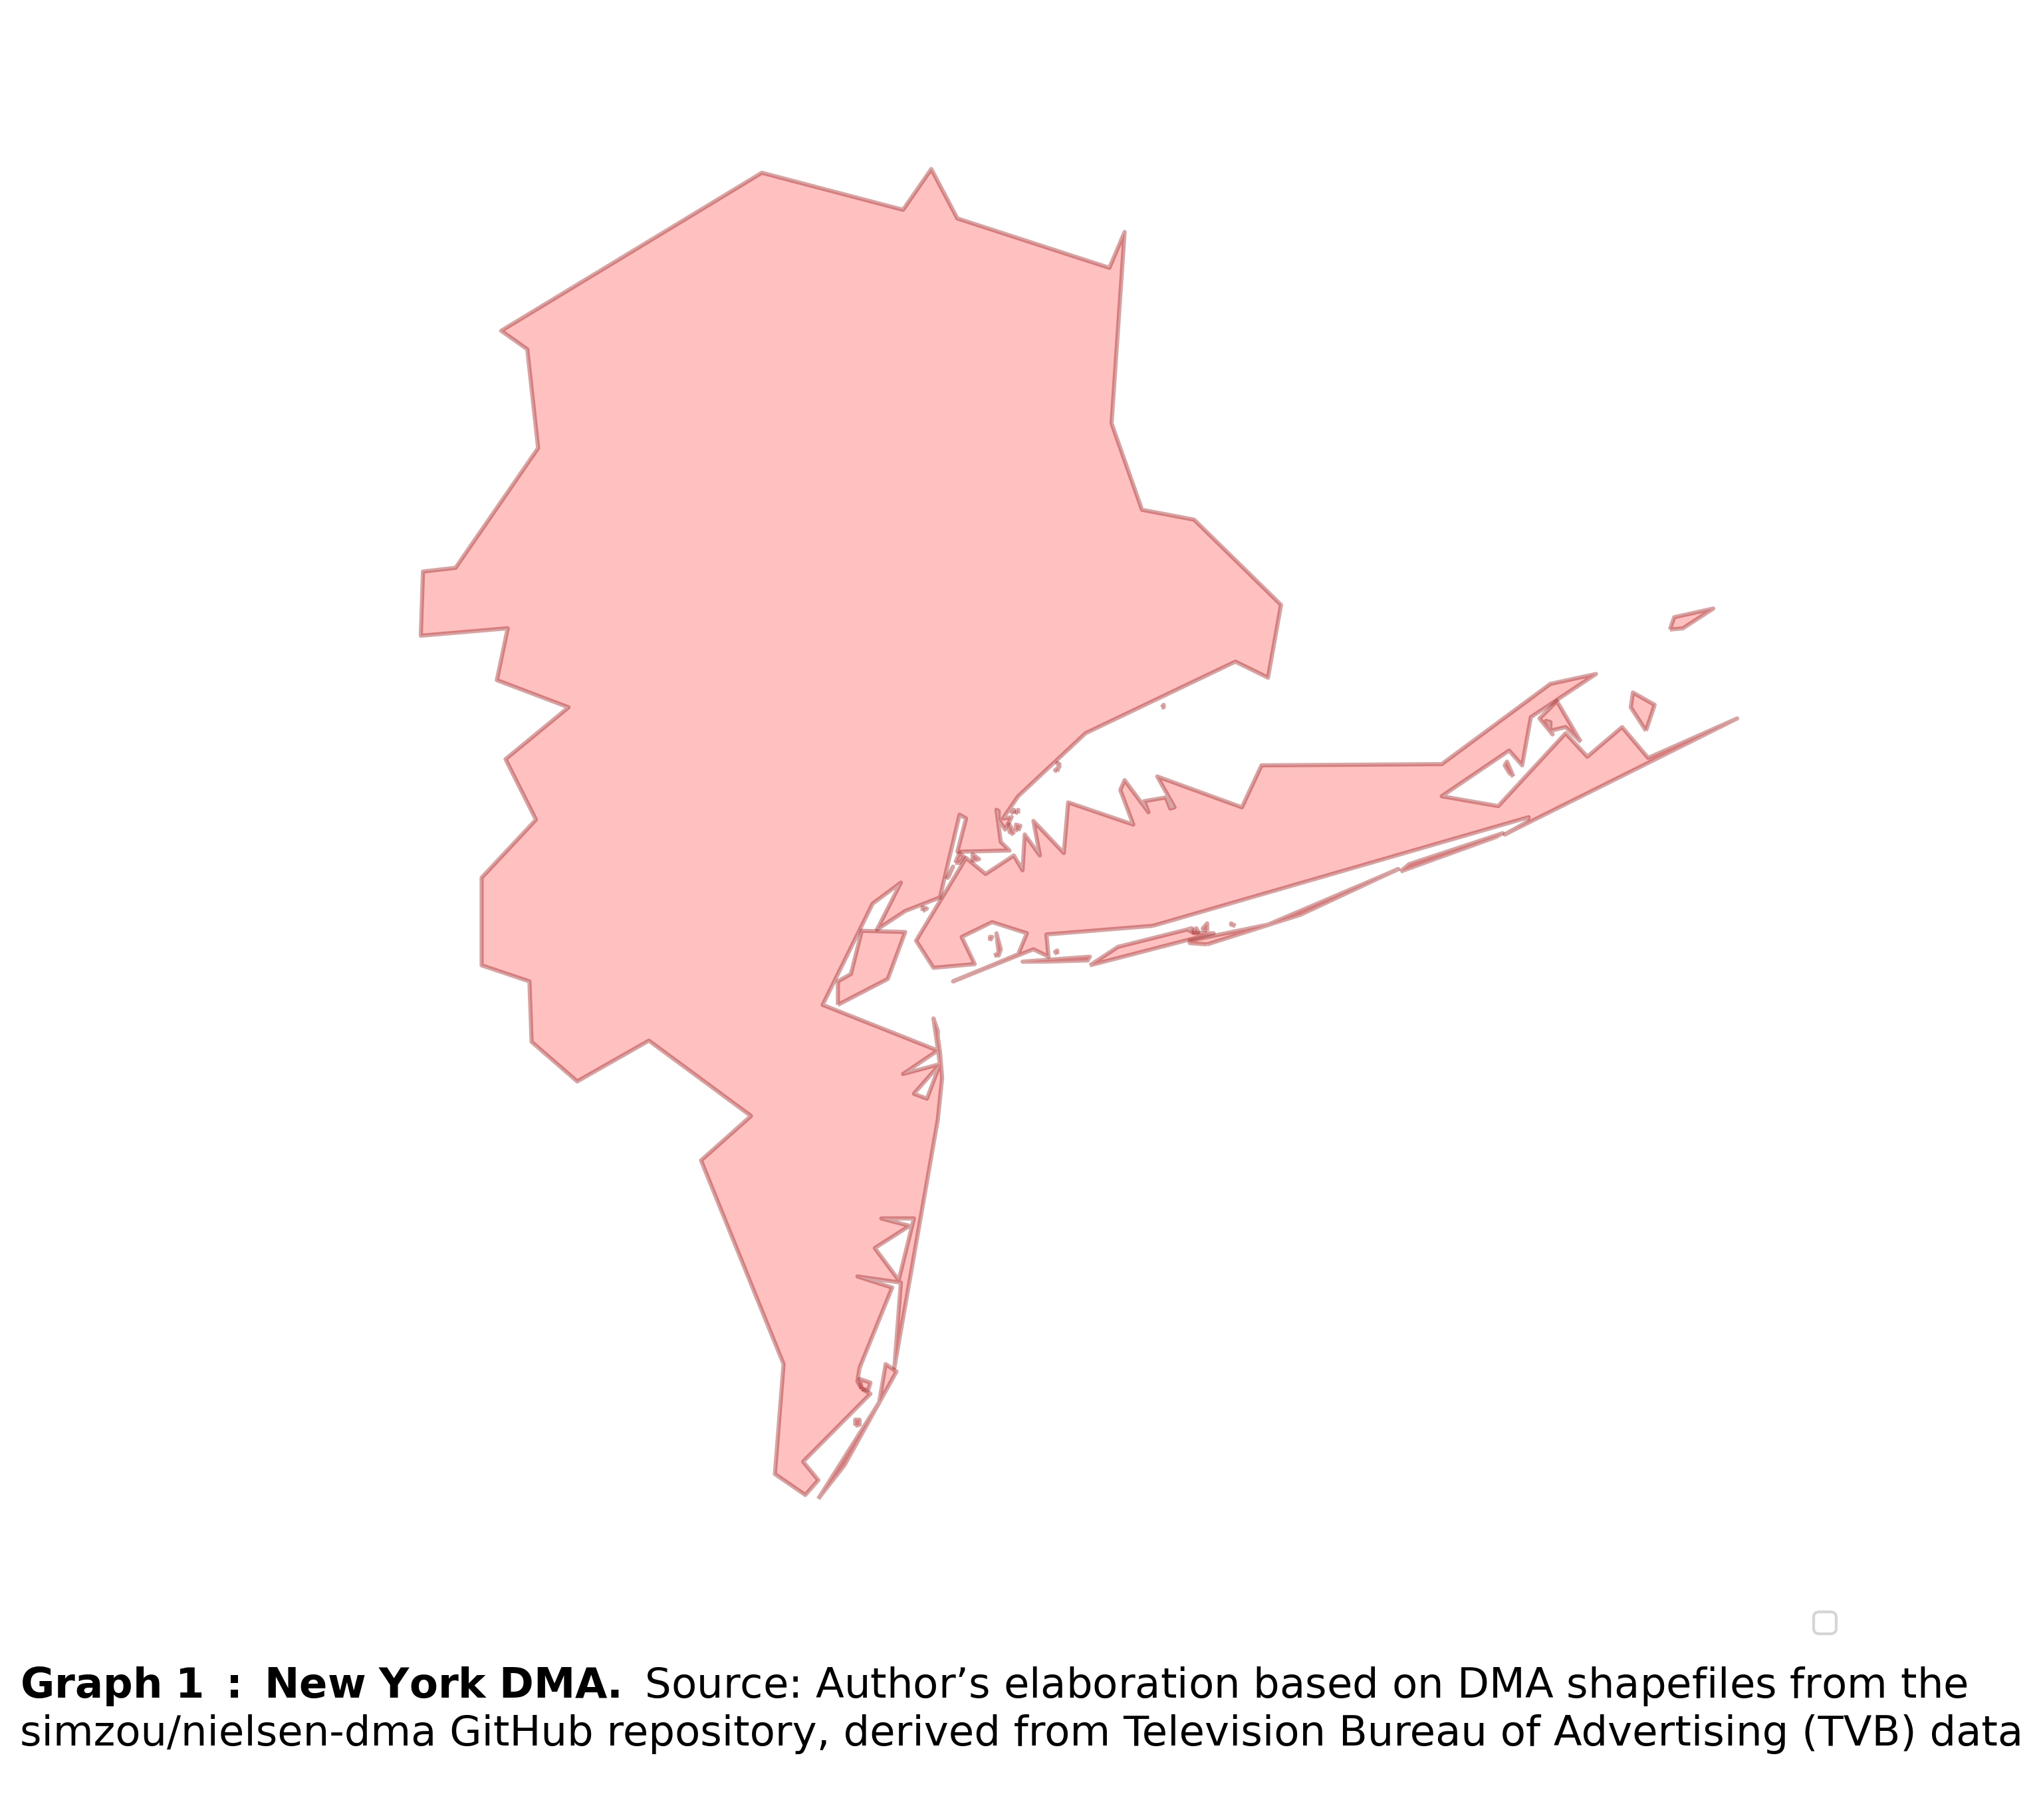

In [59]:
import geopandas as gpd
import matplotlib.pyplot as plt

# --------------------------------------------------
# File path
# --------------------------------------------------
dma_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/DMA_data/nielsen-dma-master/nielsen_dma.json"

# --------------------------------------------------
# Load DMA data
# --------------------------------------------------
dmas = gpd.read_file(dma_fp)

# --------------------------------------------------
# Set CRS
# --------------------------------------------------
original_crs = "EPSG:4269"
dmas = dmas.to_crs(original_crs)

# --------------------------------------------------
# Filter for New York DMA
# --------------------------------------------------
ny_dma = dmas[dmas["dma1"].str.contains("New York", case=False, na=False)].copy()

# --------------------------------------------------
# Plot ONLY New York DMA
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 12), dpi=300)

ny_dma.plot(
    ax=ax,
    color="#ff4d4d",
    alpha=0.35,
    edgecolor="darkred",
    linewidth=1.5,
    label="New York DMA"
)

# --------------------------------------------------
# Zoom to DMA extent
# --------------------------------------------------
minx, miny, maxx, maxy = ny_dma.total_bounds
padding = 0.3

ax.set_xlim(minx - padding, maxx + padding)
ax.set_ylim(miny - padding, maxy + padding)

# --------------------------------------------------
# Final formatting
# --------------------------------------------------

ax.set_axis_off()
ax.legend(loc="lower right", frameon=True)

# Make space at the bottom for caption
plt.subplots_adjust(bottom=0.2)  # increase from default (~0.1) as needed

# Place caption inside the figure, but in the extra space below axes
fig.text(
    0.07, 0.14,  # x = left, y = in the space below axes
    r"$\bf{Graph}$ $\bf{1}$ $\bf{:}$ $\bf{New}$ $\bf{York}$ $\bf{DMA.}$ "
    "Source: Author’s elaboration based on DMA shapefiles from the\n" 
    "simzou/nielsen-dma GitHub repository, derived from Television Bureau of Advertising (TVB) data\n",
    ha='left', fontsize=15
)


# --------------------------------------------------
# Save
# --------------------------------------------------
plt.savefig(
    "/Users/oliverraab/Desktop/CUNY/8_semester/Blog/2/ny_dma.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


# NY DMA + Counties + Overlay

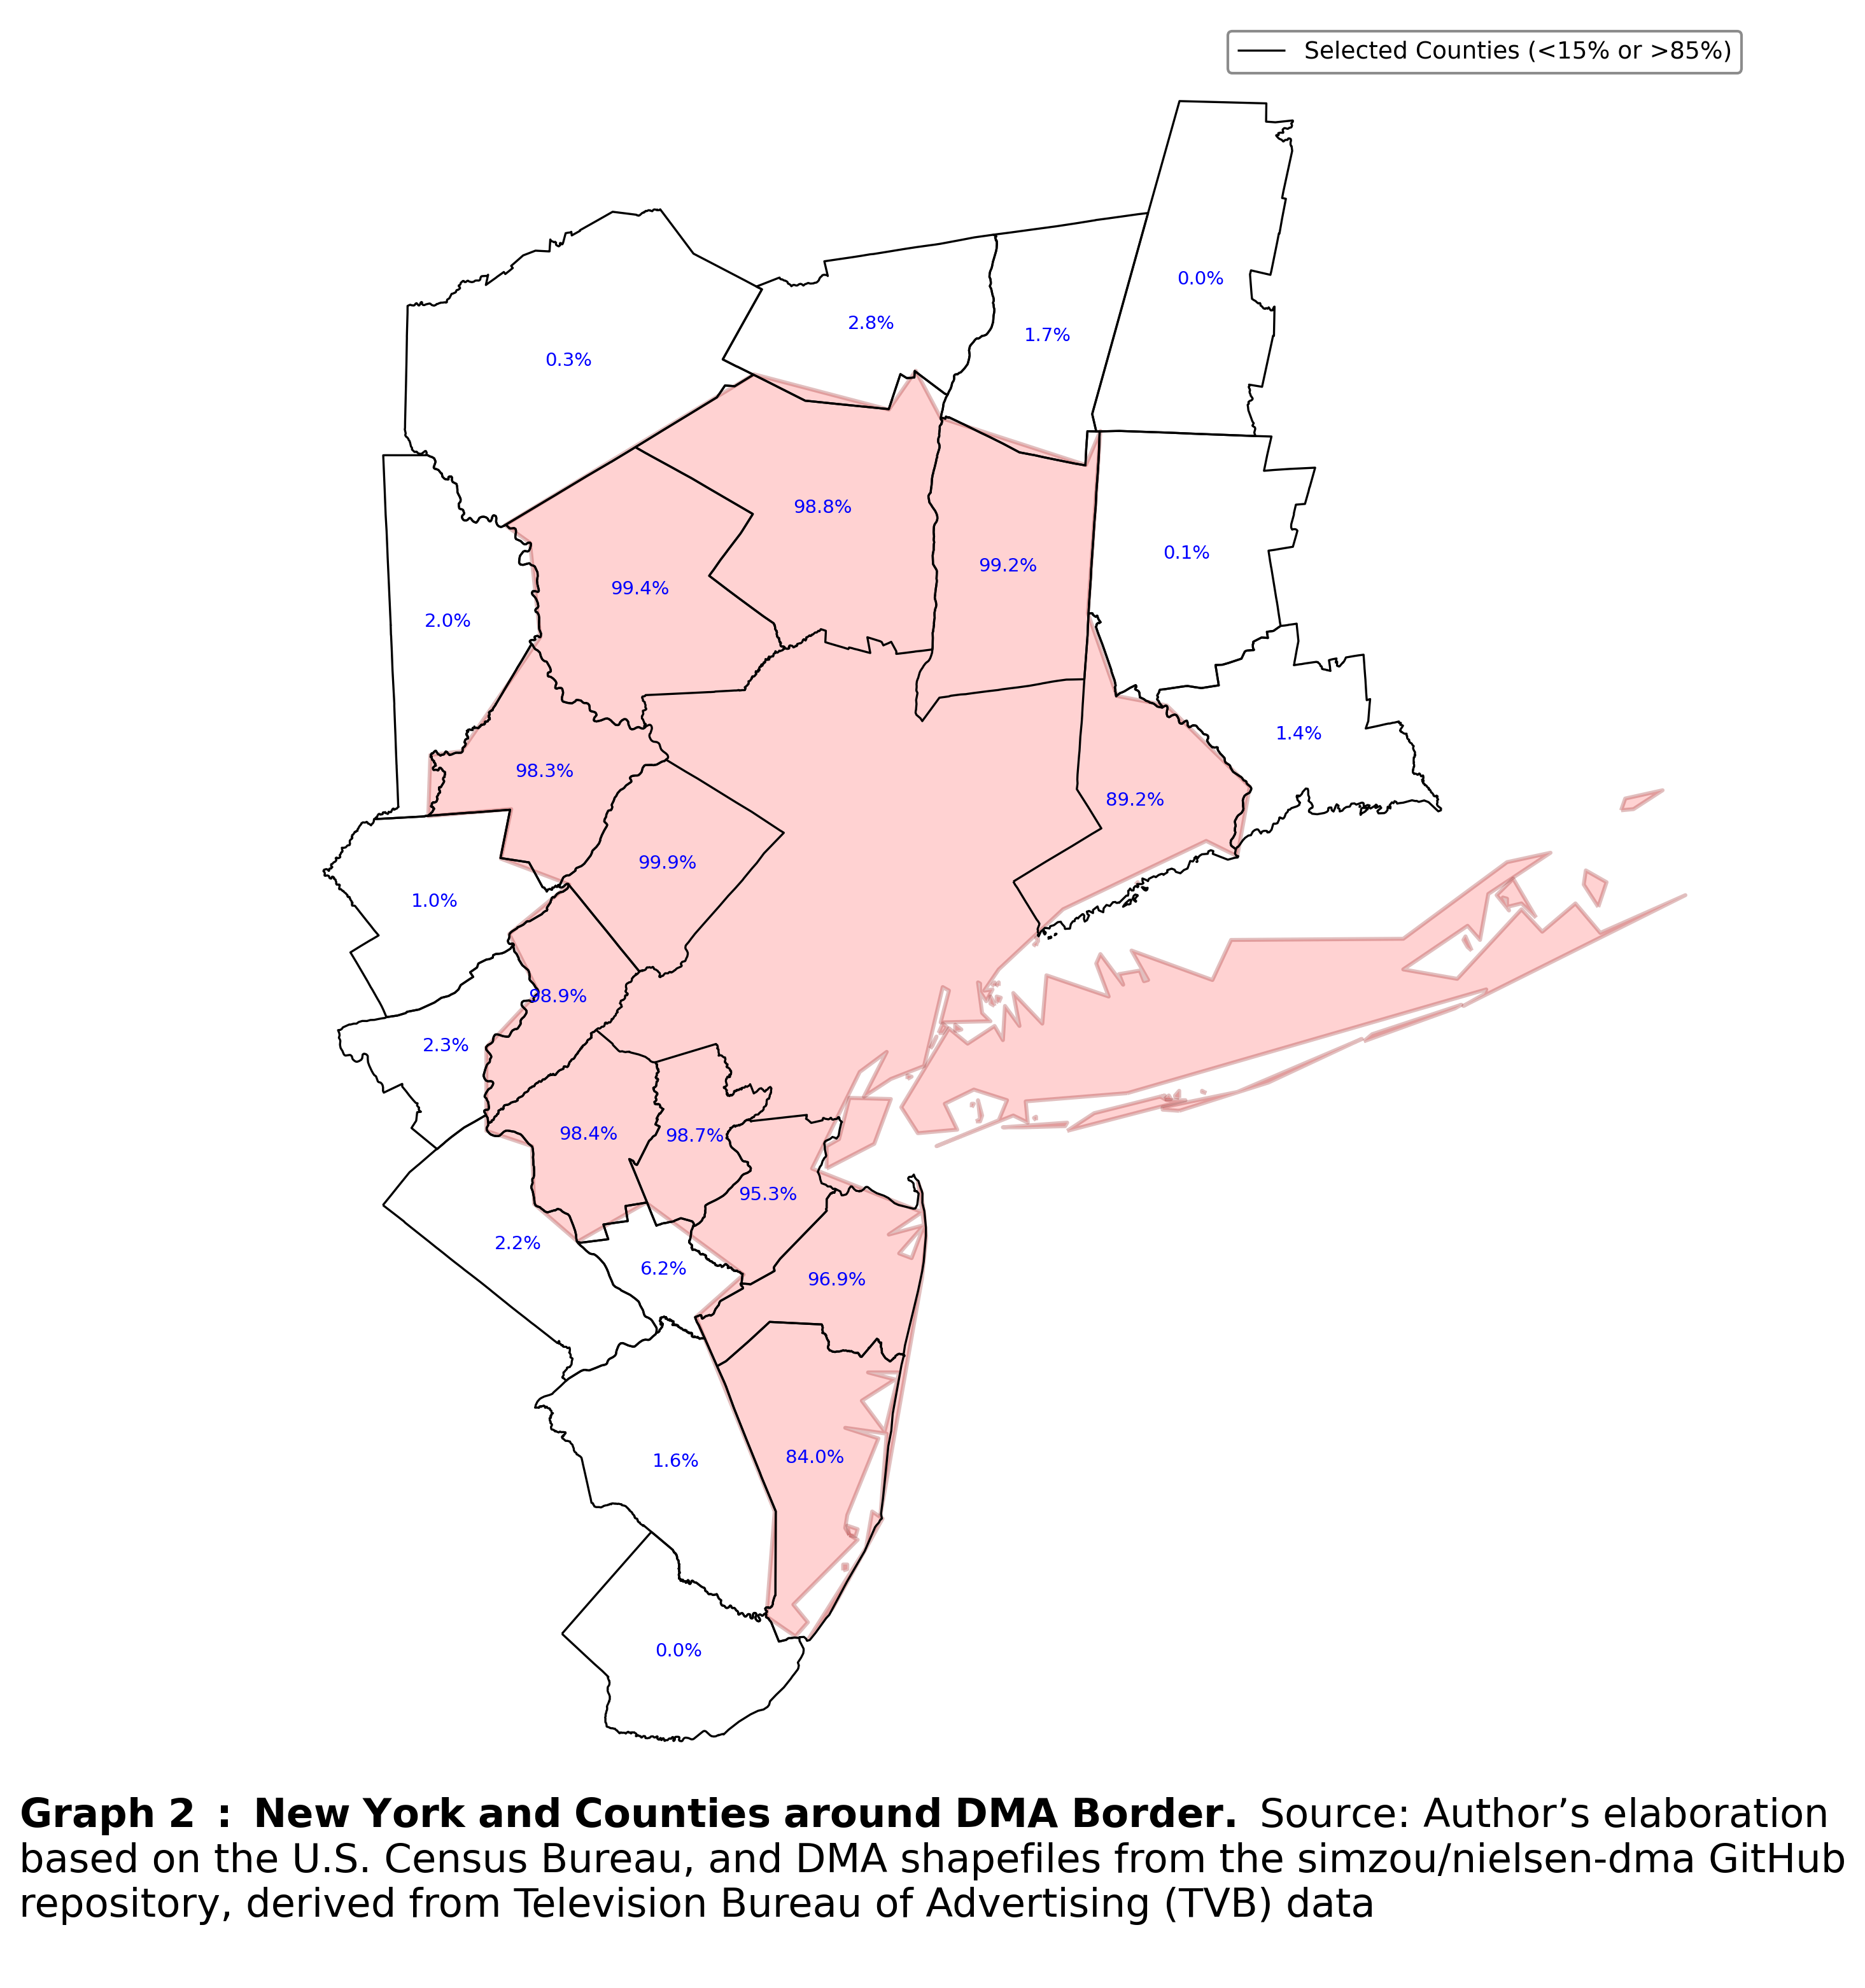

In [56]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# File paths
dma_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/DMA_data/nielsen-dma-master/nielsen_dma.json"
zip_shapefile_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/ZIP_code_coordinates_new/tl_2020_us_zcta520/tl_2020_us_zcta520.shp"
county_shapefile_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/County_coordinates_new/2018/cb_2018_us_county_500k/cb_2018_us_county_500k.shp"

# Load data
dmas = gpd.read_file(dma_fp)
zip_gdf = gpd.read_file(zip_shapefile_fp)
county_gdf = gpd.read_file(county_shapefile_fp)

# Set and align CRS
original_crs = "EPSG:4269"
zip_gdf = zip_gdf.set_crs(original_crs)
county_gdf = county_gdf.to_crs(original_crs)
dmas = dmas.to_crs(original_crs)

# Filter for New York DMA
ny_dma = dmas[dmas['dma1'].str.contains("New York", case=False, na=False)]

# Project to CRS in meters
projected_crs = "EPSG:5070"
ny_dma_proj = ny_dma.to_crs(projected_crs)
county_proj = county_gdf.to_crs(projected_crs)
ny_dma_proj["geometry"] = ny_dma_proj["geometry"].buffer(0)
ny_dma_union = ny_dma_proj.unary_union.buffer(0)

# 3-mile buffer band around DMA
buffer_distance_meters = 4828.03
outer_buffer = ny_dma_union.buffer(buffer_distance_meters)
inner_buffer = ny_dma_union.buffer(-buffer_distance_meters)
dma_border_band = outer_buffer.difference(inner_buffer)

# Select counties intersecting the DMA border band
band_counties = county_proj[county_proj.geometry.intersects(dma_border_band)].copy()

# Calculate % overlay with DMA
band_counties["area_total"] = band_counties.geometry.area
band_counties["area_overlap"] = band_counties.geometry.intersection(ny_dma_union).area
band_counties["pct_overlap"] = band_counties["area_overlap"] / band_counties["area_total"]

# Split into low (<15%) and high (>85%) DMA overlap
low = band_counties[band_counties["pct_overlap"] < 0.15].copy()
high = band_counties[band_counties["pct_overlap"] > 0.80].copy()

# Use spatial index for speed
high_sindex = high.sindex

# Find pairs of counties (low & high) within 1 mile of each other
valid_low = set()
valid_high = set()
proximity_threshold = 1609.34  # 1 mile in meters

for i, low_row in low.iterrows():
    possible_matches = list(high_sindex.intersection(low_row.geometry.buffer(proximity_threshold).bounds))
    for j in possible_matches:
        high_row = high.iloc[j]
        if low_row.geometry.distance(high_row.geometry) <= proximity_threshold:
            valid_low.add(i)
            valid_high.add(high.index[j])

# Extract matching counties
final_low = low.loc[valid_low]
final_high = high.loc[valid_high]
final_counties = pd.concat([final_low, final_high]).drop_duplicates()

# Reproject back for plotting
final_counties = final_counties.to_crs(original_crs)
ny_dma = ny_dma.to_crs(original_crs)

# Plot
fig, ax = plt.subplots(figsize=(12, 12), dpi=300)

final_counties.boundary.plot(ax=ax, color='black', linewidth=0.8, label='Selected Counties (<15% or >85%)')
ny_dma.plot(ax=ax, color='#ff4d4d', alpha=0.25, edgecolor='darkred', linewidth=1.5, label='New York DMA')

# Annotate counties with % overlap
for _, row in final_counties.iterrows():
    centroid = row.geometry.centroid
    label = f"{row['pct_overlap']*100:.1f}%"
    ax.text(centroid.x, centroid.y, label, fontsize=7, ha='center', va='center', color='blue')

# Finalize plot
ax.set_axis_off()
ax.legend(loc='upper right', fontsize=9, frameon=True, framealpha=0.9, edgecolor='gray')
plt.tight_layout()

# Make space at the bottom for caption
plt.subplots_adjust(bottom=0.2)  # increase from default (~0.1) as needed

# Place caption inside the figure, but in the extra space below axes
fig.text(
    0.07, 0.14,  # x = left, y = in the space below axes
    r"$\bf{Graph}$ $\bf{2}$ $\bf{:}$ $\bf{New}$ $\bf{York}$ $\bf{and}$ $\bf{Counties}$ $\bf{around}$ $\bf{DMA}$ $\bf{Border.}$ "
    "Source: Author’s elaboration\n" 
    "based on the U.S. Census Bureau, and DMA shapefiles from the simzou/nielsen-dma GitHub\n"
    "repository, derived from Television Bureau of Advertising (TVB) data\n",
    ha='left', fontsize=15
)

# --------------------------------------------------
# SAVE FIGURE HERE
# --------------------------------------------------
plt.savefig(
    "/Users/oliverraab/Desktop/CUNY/8_semester/Blog/2/ny_dma_border_counties.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


# NY + Bundles

/Users/oliverraab/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


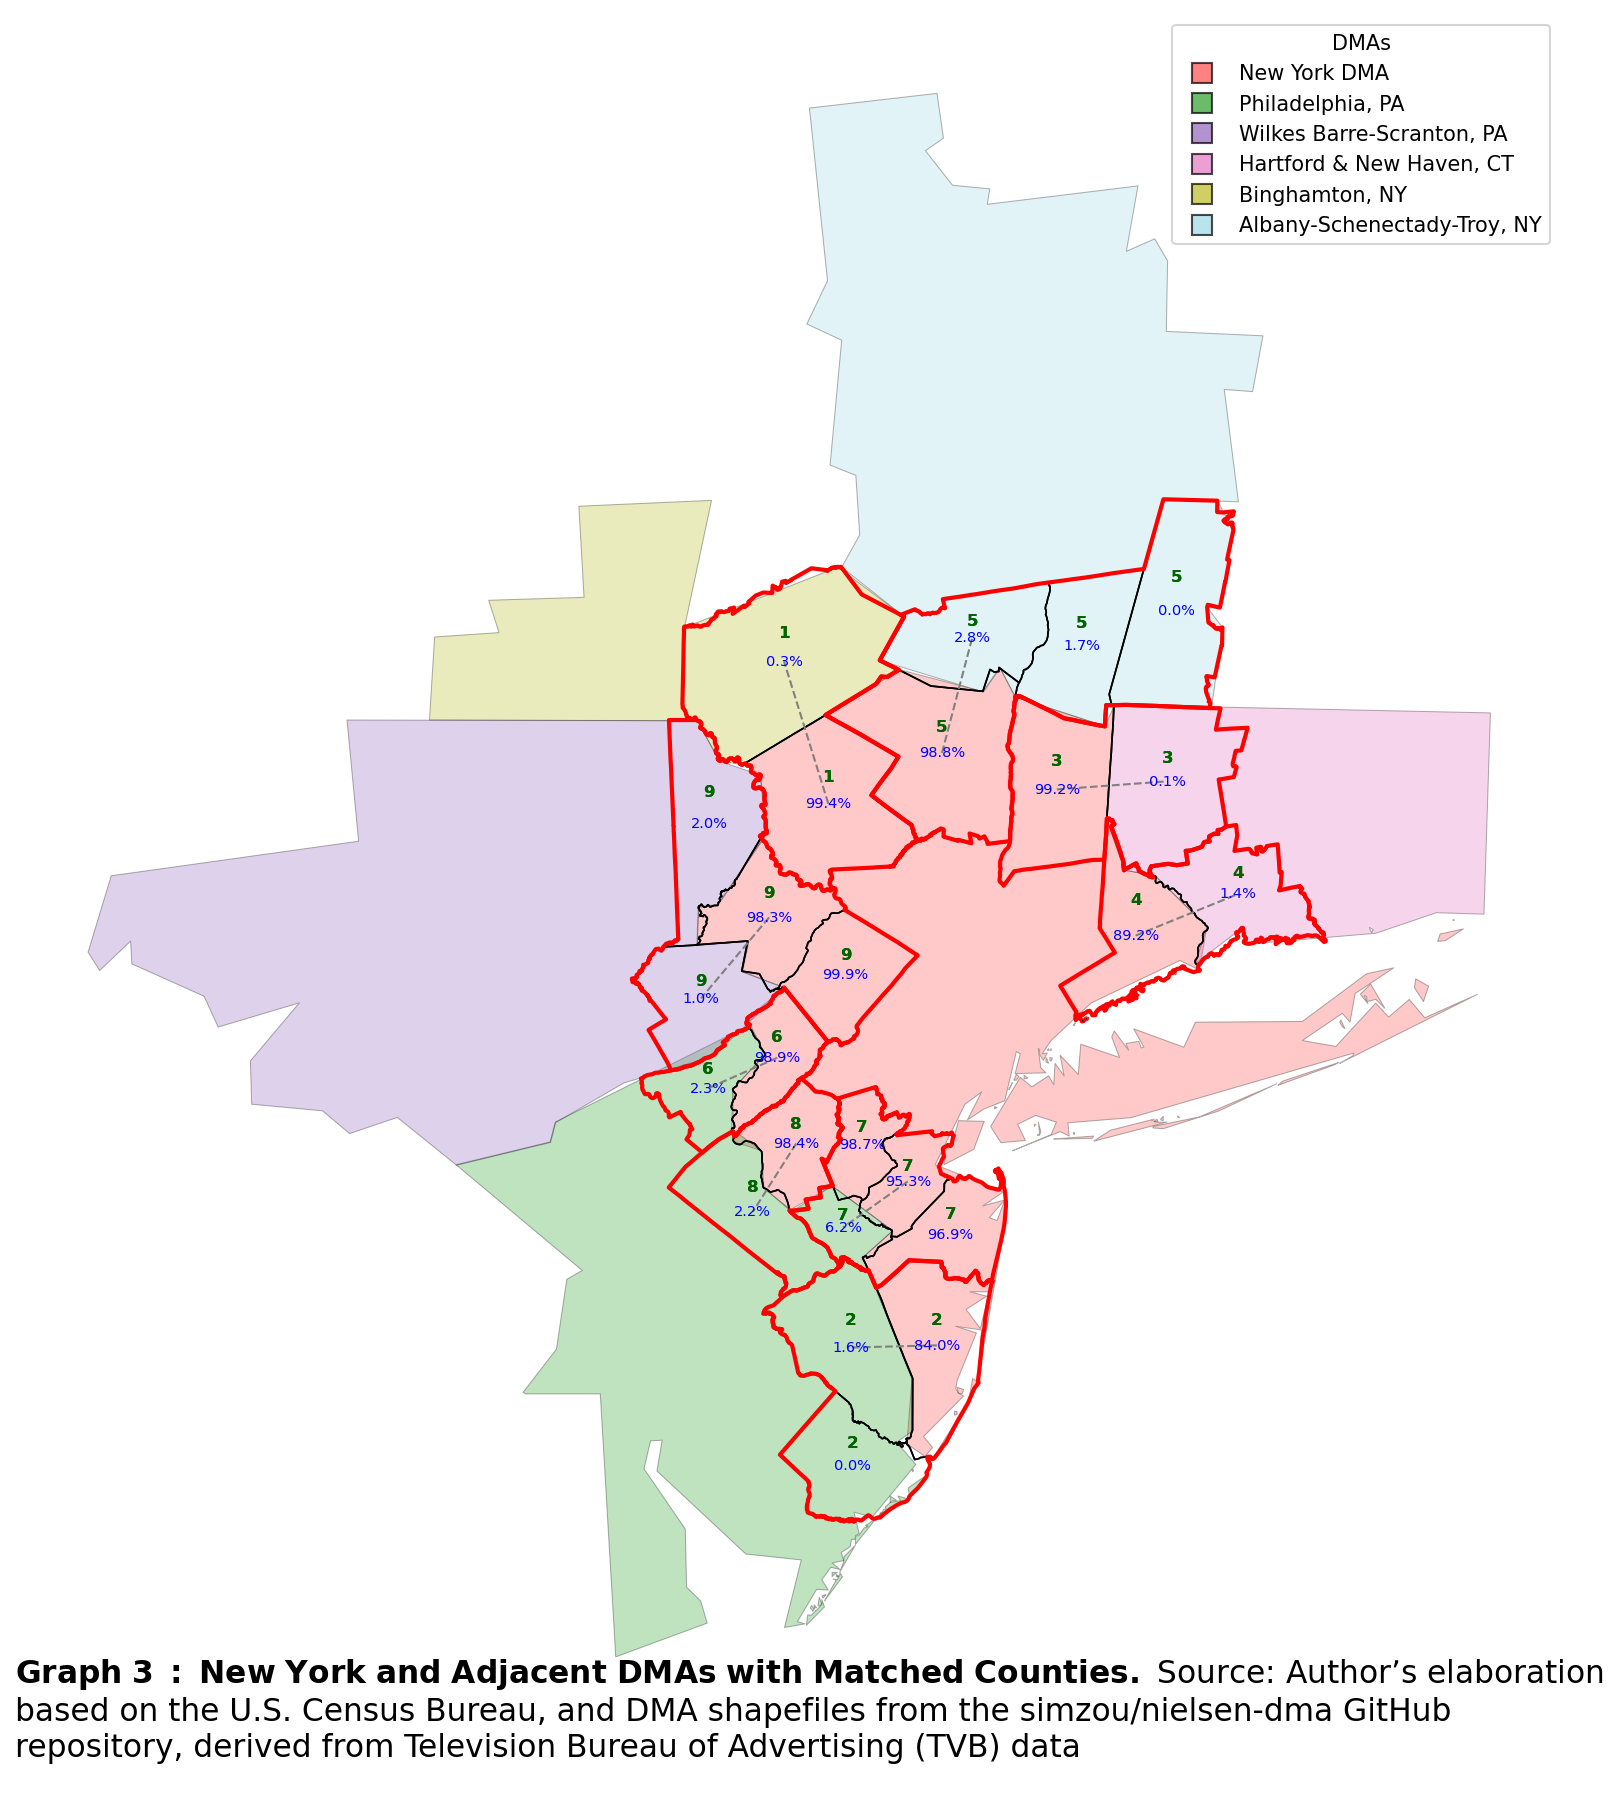

In [24]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from collections import defaultdict
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from shapely.geometry import MultiPolygon
from shapely.geometry import Point



# File paths
dma_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/DMA_data/nielsen-dma-master/nielsen_dma.json"
zip_shapefile_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/ZIP_code_coordinates_new/tl_2020_us_zcta520/tl_2020_us_zcta520.shp"
county_shapefile_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/County_coordinates_new/2018/cb_2018_us_county_500k/cb_2018_us_county_500k.shp"
zip_flags_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Analysis/ZIP_code_alternative_solution(contain_pyhon_file_with_DMA_calculation)/zip_duplicates.dta"

# Load and align CRS
dmas = gpd.read_file(dma_fp).to_crs("EPSG:4269")
zip_gdf = gpd.read_file(zip_shapefile_fp).set_crs("EPSG:4269")
county_gdf = gpd.read_file(county_shapefile_fp).to_crs("EPSG:4269")

# --- Identify adjacent DMAs and store for plotting only ---
projected_crs = "EPSG:5070"
dmas_proj = dmas.to_crs(projected_crs)
dmas_proj["geometry"] = dmas_proj["geometry"].buffer(0)
dmas_proj = dmas_proj[dmas_proj.is_valid]

ny_dma_proj = dmas_proj[dmas['dma1'].str.contains("New York", case=False, na=False)].copy()
ny_union = ny_dma_proj.unary_union

sindex = dmas_proj.sindex
adjacent_candidates = list(sindex.intersection(ny_union.buffer(0.1).bounds))
adjacent_dmas = dmas_proj.iloc[adjacent_candidates]
adjacent_dmas = adjacent_dmas[
    (adjacent_dmas.geometry.touches(ny_union) | adjacent_dmas.geometry.intersects(ny_union)) &
    (~adjacent_dmas["dma1"].str.contains("New York", case=False, na=False))
]
adjacent_dmas = adjacent_dmas.to_crs("EPSG:4269")  # for plotting only

# --- Prepare DMA coloring ---
ny_dma = dmas[dmas['dma1'].str.contains("New York", case=False, na=False)]
ny_dma["group"] = "New York DMA"
adjacent_dmas["group"] = adjacent_dmas["dma1"]
dma_combined = pd.concat([ny_dma, adjacent_dmas], ignore_index=True)

# Assign each DMA a different color
unique_names = dma_combined["group"].unique()
n_colors = len(unique_names)
color_map = cm.get_cmap('tab20', n_colors)
colors = [mcolors.to_hex(color_map(i)) for i in range(n_colors)]
name_to_color = dict(zip(unique_names, colors))

# Override New York color manually
name_to_color["New York DMA"] = "#ff4d4d"  # bright red

# Map colors
dma_combined["color"] = dma_combined["group"].map(name_to_color)
# --- ORIGINAL LOGIC STARTS HERE ---

# Load and filter ZIPs based on .dta file
zip_flags_df = pd.read_stata(zip_flags_fp)
zip_flags_df["zipcode"] = zip_flags_df["zipcode"].astype(str).str.zfill(5)

# Filter ZIPs
zip_gdf = zip_gdf[zip_gdf["ZCTA5CE20"].isin(zip_flags_df["zipcode"])]
zip_gdf = zip_gdf.to_crs("EPSG:4269")

# Project to meters for spatial calculations
ny_dma_proj = ny_dma.to_crs(projected_crs)
county_proj = county_gdf.to_crs(projected_crs)
ny_dma_proj["geometry"] = ny_dma_proj["geometry"].buffer(0)
ny_dma_union = ny_dma_proj.unary_union.buffer(0)

# 3-mile DMA buffer band
buffer_distance = 4828.03
outer = ny_dma_union.buffer(buffer_distance)
inner = ny_dma_union.buffer(-buffer_distance)
dma_band = outer.difference(inner)

# Filter counties that intersect band
band_counties = county_proj[county_proj.geometry.intersects(dma_band)].copy()
band_counties["area_total"] = band_counties.geometry.area
band_counties["area_overlap"] = band_counties.geometry.intersection(ny_dma_union).area
band_counties["pct_overlap"] = band_counties["area_overlap"] / band_counties["area_total"]

# Ensure DMAs are in same projection
dma_polygons = dmas_proj.copy()

# Initialize column
band_counties["dma_name"] = None

# Iterate over counties to assign DMA based on ≥80% area overlap
for idx, county_row in band_counties.iterrows():
    county_geom = county_row.geometry
    county_area = county_geom.area
    for _, dma_row in dma_polygons.iterrows():
        dma_geom = dma_row.geometry
        intersection_area = county_geom.intersection(dma_geom).area
        if (intersection_area / county_area) >= 0.80:
            band_counties.at[idx, "dma_name"] = dma_row["dma1"]
            break  # stop once first DMA with ≥80% match is found


# Subset
low = band_counties[band_counties["pct_overlap"] < 0.15].copy()
high = band_counties[band_counties["pct_overlap"] > 0.80].copy()

# Use spatial index for proximity filtering
high_sindex = high.sindex
proximity_threshold = 1609.34
valid_low, valid_high = set(), set()

for i, low_row in low.iterrows():
    candidates = list(high_sindex.intersection(low_row.geometry.buffer(proximity_threshold).bounds))
    for j in candidates:
        high_row = high.iloc[j]
        if low_row.geometry.distance(high_row.geometry) <= proximity_threshold:
            valid_low.add(i)
            valid_high.add(high.index[j])

# Only use proximity-filtered counties for centroid matching
filtered_low = low.loc[valid_low].copy()
filtered_high = high.loc[valid_high].copy()

# Compute centroids
filtered_low["centroid"] = filtered_low.geometry.centroid
filtered_high["centroid"] = filtered_high.geometry.centroid

# Pair each high with its closest low
pairs = []
for h_idx, h_row in filtered_high.iterrows():
    filtered_low["dist"] = filtered_low["centroid"].apply(lambda c: c.distance(h_row["centroid"]))
    closest_l_idx = filtered_low["dist"].idxmin()
    pairs.append((h_idx, closest_l_idx))

# Reproject for plotting
final_counties = pd.concat([filtered_low, filtered_high]).drop_duplicates().to_crs("EPSG:4269")

# Plot
fig, ax = plt.subplots(figsize=(12, 12), dpi=150)

# Plot each DMA in its unique color
for _, row in dma_combined.iterrows():
    row_gdf = gpd.GeoDataFrame([row], crs=dma_combined.crs)
    row_gdf.plot(
        ax=ax,
        color=row["color"],
        edgecolor='black',
        linewidth=0.5,
        alpha=0.3,
        label=row["group"]
    )

# Annotate overlap
for _, row in final_counties.iterrows():
    c = row.geometry.centroid
    ax.text(c.x, c.y, f"{row['pct_overlap']*100:.1f}%", fontsize=7, ha='center', va='center', color='blue')

# --- Begin Modified Bundle Logic ---

# --- Begin Modified Bundle Logic ---

# Step 1: Match low counties with unique DMA to closest high counties

# Compute value counts for DMA names among low overlap counties
dma_counts_low = filtered_low["dma_name"].value_counts()

# Identify low counties with unique DMA name
unique_dma_lows = filtered_low[filtered_low["dma_name"].isin(dma_counts_low[dma_counts_low == 1].index)].copy()

# Prepare tracking
mutual_pairs = []
matched_high = set()
matched_low = set()

# Match each unique DMA low county to its closest unmatched high county
for l_idx, l_row in unique_dma_lows.iterrows():
    if pd.isnull(l_row["dma_name"]):
        continue  # skip if DMA not assigned

    # Only consider unmatched high counties
    available_high = filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()

    if not available_high.empty:
        available_high["dist"] = available_high["centroid"].apply(lambda c: c.distance(l_row["centroid"]))
        closest_h_idx = available_high["dist"].idxmin()

        # Record match
        mutual_pairs.append((closest_h_idx, l_idx))
        matched_high.add(closest_h_idx)
        matched_low.add(l_idx)

        
# Step 2: Re-match unmatched using same logic, ensuring border adjacency
unmatched_high = filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()
unmatched_low = filtered_low.loc[~filtered_low.index.isin(matched_low)].copy()

high_to_low = {}
low_to_high = {}

# Only consider unmatched pairs that touch
for h_idx, h_row in unmatched_high.iterrows():
    touching_lows = unmatched_low[unmatched_low.geometry.touches(h_row.geometry)].copy()
    if touching_lows.empty:
        continue
    touching_lows["dist"] = touching_lows["centroid"].apply(lambda c: c.distance(h_row["centroid"]))
    closest_l_idx = touching_lows["dist"].idxmin()
    high_to_low[h_idx] = closest_l_idx

for l_idx, l_row in unmatched_low.iterrows():
    touching_highs = unmatched_high[unmatched_high.geometry.touches(l_row.geometry)].copy()
    if touching_highs.empty:
        continue
    touching_highs["dist"] = touching_highs["centroid"].apply(lambda c: c.distance(l_row["centroid"]))
    closest_h_idx = touching_highs["dist"].idxmin()
    low_to_high[l_idx] = closest_h_idx

# Add second-round mutual matches
for h_idx, l_idx in high_to_low.items():
    if low_to_high.get(l_idx) == h_idx:
        if h_idx not in matched_high and l_idx not in matched_low:
            mutual_pairs.append((h_idx, l_idx))
            matched_high.add(h_idx)
            matched_low.add(l_idx)


# Step 3: Re-match remaining unmatched using same mutual closest logic with adjacency

still_unmatched_high = filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()
still_unmatched_low = filtered_low.loc[~filtered_low.index.isin(matched_low)].copy()

high_to_low = {}
low_to_high = {}

for h_idx, h_row in still_unmatched_high.iterrows():
    touching_lows = still_unmatched_low[still_unmatched_low.geometry.touches(h_row.geometry)].copy()
    if touching_lows.empty:
        continue
    touching_lows["dist"] = touching_lows["centroid"].apply(lambda c: c.distance(h_row["centroid"]))
    closest_l_idx = touching_lows["dist"].idxmin()
    high_to_low[h_idx] = closest_l_idx

for l_idx, l_row in still_unmatched_low.iterrows():
    touching_highs = still_unmatched_high[still_unmatched_high.geometry.touches(l_row.geometry)].copy()
    if touching_highs.empty:
        continue
    touching_highs["dist"] = touching_highs["centroid"].apply(lambda c: c.distance(l_row["centroid"]))
    closest_h_idx = touching_highs["dist"].idxmin()
    low_to_high[l_idx] = closest_h_idx

# Add third-round mutual matches
for h_idx, l_idx in high_to_low.items():
    if low_to_high.get(l_idx) == h_idx:
        if h_idx not in matched_high and l_idx not in matched_low:
            mutual_pairs.append((h_idx, l_idx))
            matched_high.add(h_idx)
            matched_low.add(l_idx)    

# Convert mutual pairs into bundle structure
bundles = []
county_to_bundle = {}

for h_idx, l_idx in mutual_pairs:
    bundle = {h_idx, l_idx}
    bundle_idx = len(bundles)
    bundles.append(bundle)
    county_to_bundle[h_idx] = bundle_idx
    county_to_bundle[l_idx] = bundle_idx
    
    
# Compute centroid of each bundle as centroid of the union of its counties' geometries
bundle_centroids = []
for bundle in bundles:
    geoms = band_counties.loc[list(bundle)].geometry
    # Sometimes union can be MultiPolygon, so use unary_union
    union_geom = geoms.unary_union
    centroid = union_geom.centroid
    bundle_centroids.append(centroid)
    
# Step 4: Match remaining unmatched counties by DMA & nearest bundle
still_unmatched = filtered_low.loc[~filtered_low.index.isin(matched_low)].copy()
still_unmatched = pd.concat([
    still_unmatched,
    filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()
])

# Loop through unmatched counties
for idx, row in still_unmatched.iterrows():
    dma_name = band_counties.loc[idx, "dma_name"]
    if pd.isnull(dma_name):
        continue  # skip if county has no DMA assigned

    # Find bundles that include at least one county with the same DMA
    candidate_bundle_idxs = []
    for b_idx, bundle in enumerate(bundles):
        bundle_dma_names = band_counties.loc[list(bundle), "dma_name"].dropna().unique()
        if dma_name in bundle_dma_names:
            candidate_bundle_idxs.append(b_idx)

    if not candidate_bundle_idxs:
        continue  # no compatible bundle found

    # Find the closest such bundle
    county_centroid = row["centroid"]
    closest_bundle_idx = None
    min_distance = float("inf")

    for b_idx in candidate_bundle_idxs:
        bundle_centroid = bundle_centroids[b_idx]
        dist = county_centroid.distance(bundle_centroid)
        if dist < min_distance:
            min_distance = dist
            closest_bundle_idx = b_idx

    # Assign county to the closest bundle
    if closest_bundle_idx is not None:
        bundles[closest_bundle_idx].add(idx)
        county_to_bundle[idx] = closest_bundle_idx

        # Recompute bundle centroid
        bundle_geom = band_counties.loc[list(bundles[closest_bundle_idx])].geometry.unary_union
        bundle_centroids[closest_bundle_idx] = bundle_geom.centroid    
    
# --- End Modified Bundle Logic ---

# Plot counties and bundles
final_counties.boundary.plot(ax=ax, color='black', linewidth=0.8, label='Counties (<15% or >80%)')
bundle_geoms = [unary_union(band_counties.loc[list(bundle)].geometry) for bundle in bundles]
bundle_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bundle_geoms), crs=band_counties.crs).to_crs("EPSG:4269")
bundle_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Bundles')

# Annotate bundle IDs
band_counties_latlon = band_counties.to_crs("EPSG:4269")
for i, bundle in enumerate(bundles, start=1):
    for idx in bundle:
        row = band_counties_latlon.loc[idx]
        centroid = row.geometry.centroid
        y_shift = row.geometry.bounds[3] - row.geometry.centroid.y
        adjusted_y = centroid.y + 0.3 * y_shift
        ax.text(centroid.x, adjusted_y, str(i), fontsize=8, fontweight='bold', color='darkgreen', ha='center', va='center')
        

        
# Build custom legend for DMAs
handles_labels = {}
for name, color in name_to_color.items():
    handles_labels[name] = plt.Line2D([0], [0], marker='s', color='w', label=name,
                                      markerfacecolor=color, markersize=10, alpha=0.7, markeredgecolor='black')
    
# Create GeoDataFrames of centroids for plotting
low_centroids = gpd.GeoDataFrame(geometry=filtered_low["centroid"], crs=filtered_low.crs).to_crs("EPSG:4269")
high_centroids = gpd.GeoDataFrame(geometry=filtered_high["centroid"], crs=filtered_high.crs).to_crs("EPSG:4269")
bundle_centroids_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bundle_centroids), crs=band_counties.crs).to_crs("EPSG:4269")

from shapely.geometry import LineString

# Create and plot lines between each matched centroid pair
lines = []
for h_idx, l_idx in mutual_pairs:
    point1 = filtered_high.loc[h_idx, "centroid"]
    point2 = filtered_low.loc[l_idx, "centroid"]
    lines.append(LineString([point1, point2]))

lines_gdf = gpd.GeoDataFrame(geometry=lines, crs=filtered_high.crs).to_crs("EPSG:4269")
lines_gdf.plot(ax=ax, color='gray', linewidth=1, linestyle='--', label='Centroid Distance')


# Annotate bundle IDs
band_counties_latlon = band_counties.to_crs("EPSG:4269")
for i, bundle in enumerate(bundles, start=1):
    for idx in bundle:
        row = band_counties_latlon.loc[idx]
        centroid = row.geometry.centroid
        y_shift = row.geometry.bounds[3] - row.geometry.centroid.y
        adjusted_y = centroid.y + 0.3 * y_shift
        ax.text(centroid.x, adjusted_y, str(i), fontsize=8, fontweight='bold', color='darkgreen', ha='center', va='center')


plt.legend(handles=list(handles_labels.values()), title="DMAs")

plt.tight_layout()

#plt.savefig("dma_bundle_map.jpg", dpi=300, format='jpg')

# Remove axes
ax.set_axis_off()  # <-- hides all axis lines, labels, and ticks

# Add caption if desired
#fig.text(
#    0.1, 0.09,  # bottom-left corner
#    r"$\bf{Graph}$ $\bf{3}$ $\bf{:}$ $\bf{New}$ $\bf{York}$ $\bf{and}$ $\bf{Adjacent}$ $\bf{DMAs}$ $\bf{with}$ $\bf{Matched}$ $\bf{Counties}$$ "
#    "Source: Author’s elaboration based on the U.S. Census Bureau, and DMA shapefiles from the simzou/nielsen-dma GitHub repository, derived from Television Bureau of Advertising (TVB) data",
#    ha='left', fontsize=15
#)

fig.text(
    0.08, 0.0001,  # bottom-left corner
    r"$\bf{Graph}$ $\bf{3}$ $\bf{:}$ $\bf{New}$ $\bf{York}$ $\bf{and}$ $\bf{Adjacent}$ $\bf{DMAs}$ $\bf{with}$ $\bf{Matched}$ $\bf{Counties.}$ "
    "Source: Author’s elaboration\n" 
    "based on the U.S. Census Bureau, and DMA shapefiles from the simzou/nielsen-dma GitHub\n"
    "repository, derived from Television Bureau of Advertising (TVB) data\n",
    ha='left', fontsize=15
)

plt.savefig(
    "/Users/oliverraab/Desktop/CUNY/8_semester/Blog/2/ny_dma_border_counties_bundles_1.png",
    dpi=300,
    bbox_inches="tight"
)


# Show the plot
plt.show()


# NY + Bundles 2

/Users/oliverraab/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


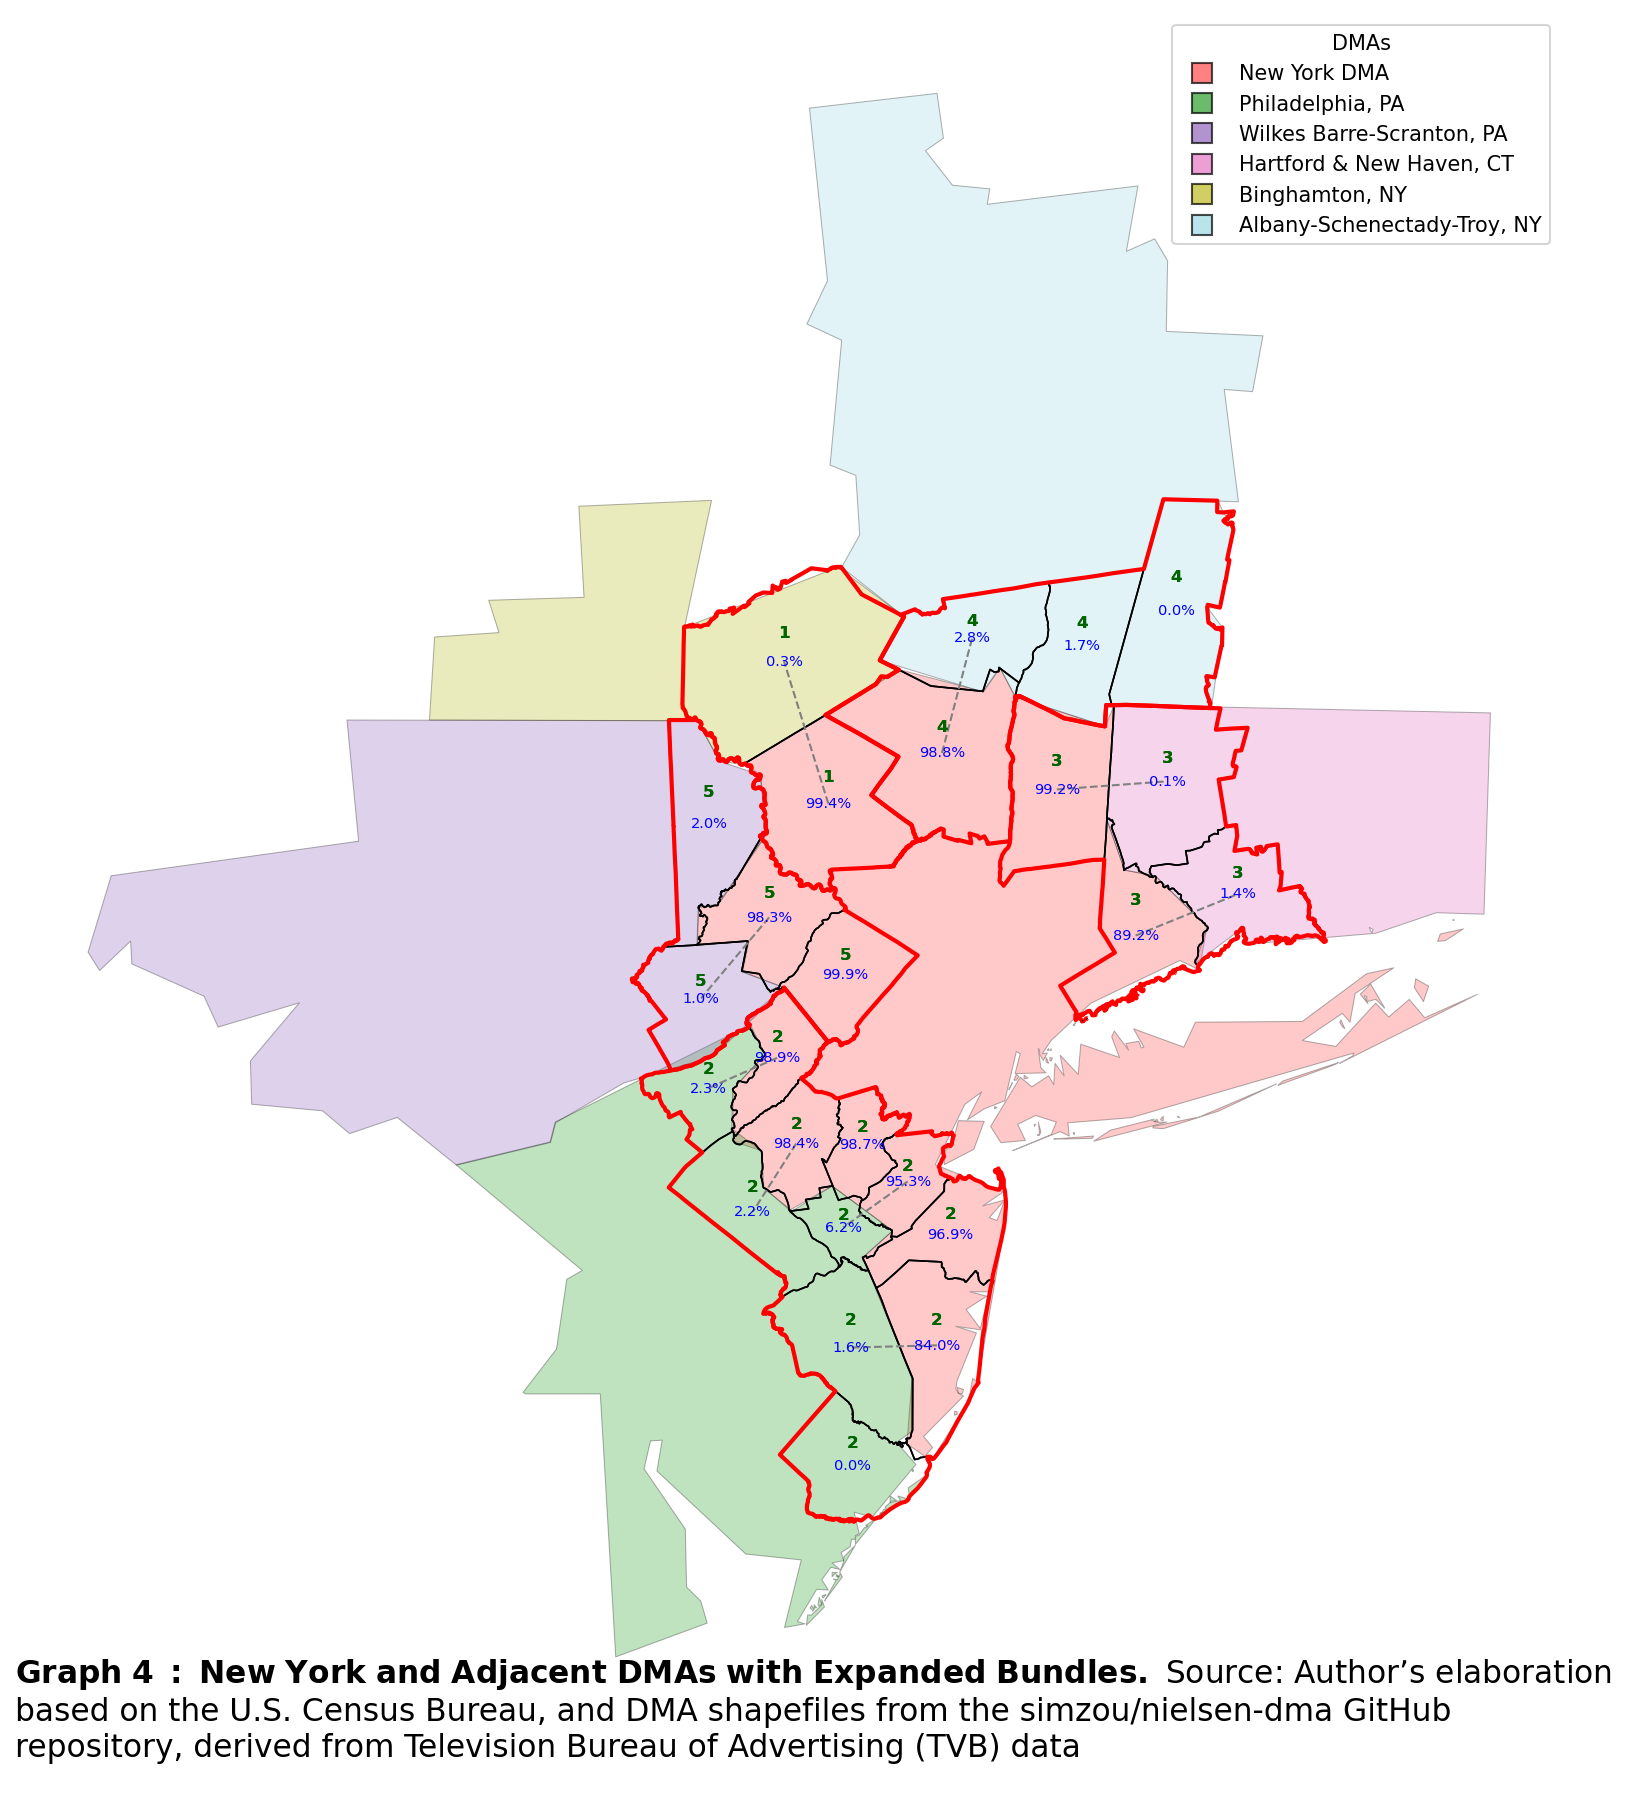

In [62]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from collections import defaultdict
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from shapely.geometry import MultiPolygon
from shapely.geometry import Point



# File paths
dma_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/DMA_data/nielsen-dma-master/nielsen_dma.json"
zip_shapefile_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/ZIP_code_coordinates_new/tl_2020_us_zcta520/tl_2020_us_zcta520.shp"
county_shapefile_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/County_coordinates_new/2018/cb_2018_us_county_500k/cb_2018_us_county_500k.shp"
zip_flags_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Analysis/ZIP_code_alternative_solution(contain_pyhon_file_with_DMA_calculation)/zip_duplicates.dta"

# Load and align CRS
dmas = gpd.read_file(dma_fp).to_crs("EPSG:4269")
zip_gdf = gpd.read_file(zip_shapefile_fp).set_crs("EPSG:4269")
county_gdf = gpd.read_file(county_shapefile_fp).to_crs("EPSG:4269")

# --- Identify adjacent DMAs and store for plotting only ---
projected_crs = "EPSG:5070"
dmas_proj = dmas.to_crs(projected_crs)
dmas_proj["geometry"] = dmas_proj["geometry"].buffer(0)
dmas_proj = dmas_proj[dmas_proj.is_valid]

ny_dma_proj = dmas_proj[dmas['dma1'].str.contains("New York", case=False, na=False)].copy()
ny_union = ny_dma_proj.unary_union

sindex = dmas_proj.sindex
adjacent_candidates = list(sindex.intersection(ny_union.buffer(0.1).bounds))
adjacent_dmas = dmas_proj.iloc[adjacent_candidates]
adjacent_dmas = adjacent_dmas[
    (adjacent_dmas.geometry.touches(ny_union) | adjacent_dmas.geometry.intersects(ny_union)) &
    (~adjacent_dmas["dma1"].str.contains("New York", case=False, na=False))
]
adjacent_dmas = adjacent_dmas.to_crs("EPSG:4269")  # for plotting only

# --- Prepare DMA coloring ---
ny_dma = dmas[dmas['dma1'].str.contains("New York", case=False, na=False)]
ny_dma["group"] = "New York DMA"
adjacent_dmas["group"] = adjacent_dmas["dma1"]
dma_combined = pd.concat([ny_dma, adjacent_dmas], ignore_index=True)

# Assign each DMA a different color
unique_names = dma_combined["group"].unique()
n_colors = len(unique_names)
color_map = cm.get_cmap('tab20', n_colors)
colors = [mcolors.to_hex(color_map(i)) for i in range(n_colors)]
name_to_color = dict(zip(unique_names, colors))

# Override New York color manually
name_to_color["New York DMA"] = "#ff4d4d"  # bright red

# Map colors
dma_combined["color"] = dma_combined["group"].map(name_to_color)
# --- ORIGINAL LOGIC STARTS HERE ---

# Load and filter ZIPs based on .dta file
zip_flags_df = pd.read_stata(zip_flags_fp)
zip_flags_df["zipcode"] = zip_flags_df["zipcode"].astype(str).str.zfill(5)

# Filter ZIPs
zip_gdf = zip_gdf[zip_gdf["ZCTA5CE20"].isin(zip_flags_df["zipcode"])]
zip_gdf = zip_gdf.to_crs("EPSG:4269")

# Project to meters for spatial calculations
ny_dma_proj = ny_dma.to_crs(projected_crs)
county_proj = county_gdf.to_crs(projected_crs)
ny_dma_proj["geometry"] = ny_dma_proj["geometry"].buffer(0)
ny_dma_union = ny_dma_proj.unary_union.buffer(0)

# 3-mile DMA buffer band
buffer_distance = 4828.03
outer = ny_dma_union.buffer(buffer_distance)
inner = ny_dma_union.buffer(-buffer_distance)
dma_band = outer.difference(inner)

# Filter counties that intersect band
band_counties = county_proj[county_proj.geometry.intersects(dma_band)].copy()
band_counties["area_total"] = band_counties.geometry.area
band_counties["area_overlap"] = band_counties.geometry.intersection(ny_dma_union).area
band_counties["pct_overlap"] = band_counties["area_overlap"] / band_counties["area_total"]

# Ensure DMAs are in same projection
dma_polygons = dmas_proj.copy()

# Initialize column
band_counties["dma_name"] = None

# Iterate over counties to assign DMA based on ≥80% area overlap
for idx, county_row in band_counties.iterrows():
    county_geom = county_row.geometry
    county_area = county_geom.area
    for _, dma_row in dma_polygons.iterrows():
        dma_geom = dma_row.geometry
        intersection_area = county_geom.intersection(dma_geom).area
        if (intersection_area / county_area) >= 0.80:
            band_counties.at[idx, "dma_name"] = dma_row["dma1"]
            break  # stop once first DMA with ≥80% match is found


# Subset
low = band_counties[band_counties["pct_overlap"] < 0.15].copy()
high = band_counties[band_counties["pct_overlap"] > 0.80].copy()

# Use spatial index for proximity filtering
high_sindex = high.sindex
proximity_threshold = 1609.34
valid_low, valid_high = set(), set()

for i, low_row in low.iterrows():
    candidates = list(high_sindex.intersection(low_row.geometry.buffer(proximity_threshold).bounds))
    for j in candidates:
        high_row = high.iloc[j]
        if low_row.geometry.distance(high_row.geometry) <= proximity_threshold:
            valid_low.add(i)
            valid_high.add(high.index[j])

# Only use proximity-filtered counties for centroid matching
filtered_low = low.loc[valid_low].copy()
filtered_high = high.loc[valid_high].copy()

# Compute centroids
filtered_low["centroid"] = filtered_low.geometry.centroid
filtered_high["centroid"] = filtered_high.geometry.centroid

# Pair each high with its closest low
pairs = []
for h_idx, h_row in filtered_high.iterrows():
    filtered_low["dist"] = filtered_low["centroid"].apply(lambda c: c.distance(h_row["centroid"]))
    closest_l_idx = filtered_low["dist"].idxmin()
    pairs.append((h_idx, closest_l_idx))

# Reproject for plotting
final_counties = pd.concat([filtered_low, filtered_high]).drop_duplicates().to_crs("EPSG:4269")

# Plot
fig, ax = plt.subplots(figsize=(12, 12), dpi=150)

# Plot each DMA in its unique color
for _, row in dma_combined.iterrows():
    row_gdf = gpd.GeoDataFrame([row], crs=dma_combined.crs)
    row_gdf.plot(
        ax=ax,
        color=row["color"],
        edgecolor='black',
        linewidth=0.5,
        alpha=0.3,
        label=row["group"]
    )

# Annotate overlap
for _, row in final_counties.iterrows():
    c = row.geometry.centroid
    ax.text(c.x, c.y, f"{row['pct_overlap']*100:.1f}%", fontsize=7, ha='center', va='center', color='blue')

# --- Begin Modified Bundle Logic ---

# --- Begin Modified Bundle Logic ---

# Step 1: Match low counties with unique DMA to closest high counties

# Compute value counts for DMA names among low overlap counties
dma_counts_low = filtered_low["dma_name"].value_counts()

# Identify low counties with unique DMA name
unique_dma_lows = filtered_low[filtered_low["dma_name"].isin(dma_counts_low[dma_counts_low == 1].index)].copy()

# Prepare tracking
mutual_pairs = []
matched_high = set()
matched_low = set()

# Match each unique DMA low county to its closest unmatched high county
for l_idx, l_row in unique_dma_lows.iterrows():
    if pd.isnull(l_row["dma_name"]):
        continue  # skip if DMA not assigned

    # Only consider unmatched high counties
    available_high = filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()

    if not available_high.empty:
        available_high["dist"] = available_high["centroid"].apply(lambda c: c.distance(l_row["centroid"]))
        closest_h_idx = available_high["dist"].idxmin()

        # Record match
        mutual_pairs.append((closest_h_idx, l_idx))
        matched_high.add(closest_h_idx)
        matched_low.add(l_idx)

        
# Step 2: Re-match unmatched using same logic, ensuring border adjacency
unmatched_high = filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()
unmatched_low = filtered_low.loc[~filtered_low.index.isin(matched_low)].copy()

high_to_low = {}
low_to_high = {}

# Only consider unmatched pairs that touch
for h_idx, h_row in unmatched_high.iterrows():
    touching_lows = unmatched_low[unmatched_low.geometry.touches(h_row.geometry)].copy()
    if touching_lows.empty:
        continue
    touching_lows["dist"] = touching_lows["centroid"].apply(lambda c: c.distance(h_row["centroid"]))
    closest_l_idx = touching_lows["dist"].idxmin()
    high_to_low[h_idx] = closest_l_idx

for l_idx, l_row in unmatched_low.iterrows():
    touching_highs = unmatched_high[unmatched_high.geometry.touches(l_row.geometry)].copy()
    if touching_highs.empty:
        continue
    touching_highs["dist"] = touching_highs["centroid"].apply(lambda c: c.distance(l_row["centroid"]))
    closest_h_idx = touching_highs["dist"].idxmin()
    low_to_high[l_idx] = closest_h_idx

# Add second-round mutual matches
for h_idx, l_idx in high_to_low.items():
    if low_to_high.get(l_idx) == h_idx:
        if h_idx not in matched_high and l_idx not in matched_low:
            mutual_pairs.append((h_idx, l_idx))
            matched_high.add(h_idx)
            matched_low.add(l_idx)


# Step 3: Re-match remaining unmatched using same mutual closest logic with adjacency

still_unmatched_high = filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()
still_unmatched_low = filtered_low.loc[~filtered_low.index.isin(matched_low)].copy()

high_to_low = {}
low_to_high = {}

for h_idx, h_row in still_unmatched_high.iterrows():
    touching_lows = still_unmatched_low[still_unmatched_low.geometry.touches(h_row.geometry)].copy()
    if touching_lows.empty:
        continue
    touching_lows["dist"] = touching_lows["centroid"].apply(lambda c: c.distance(h_row["centroid"]))
    closest_l_idx = touching_lows["dist"].idxmin()
    high_to_low[h_idx] = closest_l_idx

for l_idx, l_row in still_unmatched_low.iterrows():
    touching_highs = still_unmatched_high[still_unmatched_high.geometry.touches(l_row.geometry)].copy()
    if touching_highs.empty:
        continue
    touching_highs["dist"] = touching_highs["centroid"].apply(lambda c: c.distance(l_row["centroid"]))
    closest_h_idx = touching_highs["dist"].idxmin()
    low_to_high[l_idx] = closest_h_idx

# Add third-round mutual matches
for h_idx, l_idx in high_to_low.items():
    if low_to_high.get(l_idx) == h_idx:
        if h_idx not in matched_high and l_idx not in matched_low:
            mutual_pairs.append((h_idx, l_idx))
            matched_high.add(h_idx)
            matched_low.add(l_idx)    

# Convert mutual pairs into bundle structure
bundles = []
county_to_bundle = {}

for h_idx, l_idx in mutual_pairs:
    bundle = {h_idx, l_idx}
    bundle_idx = len(bundles)
    bundles.append(bundle)
    county_to_bundle[h_idx] = bundle_idx
    county_to_bundle[l_idx] = bundle_idx
    
    
# Compute centroid of each bundle as centroid of the union of its counties' geometries
bundle_centroids = []
for bundle in bundles:
    geoms = band_counties.loc[list(bundle)].geometry
    # Sometimes union can be MultiPolygon, so use unary_union
    union_geom = geoms.unary_union
    centroid = union_geom.centroid
    bundle_centroids.append(centroid)
    
# Step 4: Match remaining unmatched counties by DMA & nearest bundle
still_unmatched = filtered_low.loc[~filtered_low.index.isin(matched_low)].copy()
still_unmatched = pd.concat([
    still_unmatched,
    filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()
])

# Step 5: Merge bundles that share the same set of two DMAs

# Step 5.1: Build a mapping from bundle index to DMA set
bundle_dma_sets = {}
for idx, bundle in enumerate(bundles):
    dma_set = set(band_counties.loc[list(bundle), "dma_name"])
    # Only consider bundles that consist of exactly two unique DMAs
    if len(dma_set) == 2:
        bundle_dma_sets[idx] = frozenset(dma_set)

# Step 5.2: Group bundles by identical DMA sets
dma_pair_to_bundle_idxs = defaultdict(list)
for bundle_idx, dma_pair in bundle_dma_sets.items():
    dma_pair_to_bundle_idxs[dma_pair].append(bundle_idx)

# Step 5.3: Create new merged bundles
merged_bundles = []
new_county_to_bundle = {}
seen_bundle_idxs = set()

for dma_pair, bundle_idxs in dma_pair_to_bundle_idxs.items():
    # Merge all bundles with same DMA pair
    merged_county_set = set()
    for b_idx in bundle_idxs:
        merged_county_set.update(bundles[b_idx])
        seen_bundle_idxs.add(b_idx)
    
    merged_bundles.append(merged_county_set)
    new_bundle_idx = len(merged_bundles) - 1
    for c_idx in merged_county_set:
        new_county_to_bundle[c_idx] = new_bundle_idx

# Step 5.4: Add remaining unmerged bundles
for i, bundle in enumerate(bundles):
    if i in seen_bundle_idxs:
        continue  # Already merged
    merged_bundles.append(bundle)
    new_bundle_idx = len(merged_bundles) - 1
    for c_idx in bundle:
        new_county_to_bundle[c_idx] = new_bundle_idx

# Replace original bundle structures with merged ones
bundles = merged_bundles
#county_to_bundle = new_county_to_bundle




# Loop through unmatched counties
for idx, row in still_unmatched.iterrows():
    dma_name = band_counties.loc[idx, "dma_name"]
    if pd.isnull(dma_name):
        continue  # skip if county has no DMA assigned

    # Find bundles that include at least one county with the same DMA
    candidate_bundle_idxs = []
    for b_idx, bundle in enumerate(bundles):
        bundle_dma_names = band_counties.loc[list(bundle), "dma_name"].dropna().unique()
        if dma_name in bundle_dma_names:
            candidate_bundle_idxs.append(b_idx)

    if not candidate_bundle_idxs:
        continue  # no compatible bundle found

    # Find the closest such bundle
    county_centroid = row["centroid"]
    closest_bundle_idx = None
    min_distance = float("inf")

    for b_idx in candidate_bundle_idxs:
        bundle_centroid = bundle_centroids[b_idx]
        dist = county_centroid.distance(bundle_centroid)
        if dist < min_distance:
            min_distance = dist
            closest_bundle_idx = b_idx

    # Assign county to the closest bundle
    if closest_bundle_idx is not None:
        bundles[closest_bundle_idx].add(idx)
        county_to_bundle[idx] = closest_bundle_idx

        # Recompute bundle centroid
        bundle_geom = band_counties.loc[list(bundles[closest_bundle_idx])].geometry.unary_union
        bundle_centroids[closest_bundle_idx] = bundle_geom.centroid    
    
# --- End Modified Bundle Logic ---

# Plot counties and bundles
final_counties.boundary.plot(ax=ax, color='black', linewidth=0.8, label='Counties (<15% or >80%)')
bundle_geoms = [unary_union(band_counties.loc[list(bundle)].geometry) for bundle in bundles]
bundle_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bundle_geoms), crs=band_counties.crs).to_crs("EPSG:4269")
bundle_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Bundles')

# Annotate bundle IDs
band_counties_latlon = band_counties.to_crs("EPSG:4269")
for i, bundle in enumerate(bundles, start=1):
    for idx in bundle:
        row = band_counties_latlon.loc[idx]
        centroid = row.geometry.centroid
        y_shift = row.geometry.bounds[3] - row.geometry.centroid.y
        adjusted_y = centroid.y + 0.3 * y_shift
        ax.text(centroid.x, adjusted_y, str(i), fontsize=8, fontweight='bold', color='darkgreen', ha='center', va='center')
        

        
# Build custom legend for DMAs
handles_labels = {}
for name, color in name_to_color.items():
    handles_labels[name] = plt.Line2D([0], [0], marker='s', color='w', label=name,
                                      markerfacecolor=color, markersize=10, alpha=0.7, markeredgecolor='black')
    
# Create GeoDataFrames of centroids for plotting
low_centroids = gpd.GeoDataFrame(geometry=filtered_low["centroid"], crs=filtered_low.crs).to_crs("EPSG:4269")
high_centroids = gpd.GeoDataFrame(geometry=filtered_high["centroid"], crs=filtered_high.crs).to_crs("EPSG:4269")
bundle_centroids_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bundle_centroids), crs=band_counties.crs).to_crs("EPSG:4269")

from shapely.geometry import LineString

# Create and plot lines between each matched centroid pair
lines = []
for h_idx, l_idx in mutual_pairs:
    point1 = filtered_high.loc[h_idx, "centroid"]
    point2 = filtered_low.loc[l_idx, "centroid"]
    lines.append(LineString([point1, point2]))

lines_gdf = gpd.GeoDataFrame(geometry=lines, crs=filtered_high.crs).to_crs("EPSG:4269")
lines_gdf.plot(ax=ax, color='gray', linewidth=1, linestyle='--', label='Centroid Distance')


# Annotate bundle IDs
band_counties_latlon = band_counties.to_crs("EPSG:4269")
for i, bundle in enumerate(bundles, start=1):
    for idx in bundle:
        row = band_counties_latlon.loc[idx]
        centroid = row.geometry.centroid
        y_shift = row.geometry.bounds[3] - row.geometry.centroid.y
        adjusted_y = centroid.y + 0.3 * y_shift
        ax.text(centroid.x, adjusted_y, str(i), fontsize=8, fontweight='bold', color='darkgreen', ha='center', va='center')


plt.legend(handles=list(handles_labels.values()), title="DMAs")

plt.tight_layout()

#plt.savefig("dma_bundle_map.jpg", dpi=300, format='jpg')

# Remove axes
ax.set_axis_off()  # <-- hides all axis lines, labels, and ticks

# Add caption if desired
#fig.text(
#    0.1, 0.09,  # bottom-left corner
#    r"$\bf{Graph}$ $\bf{3}$ $\bf{:}$ $\bf{New}$ $\bf{York}$ $\bf{and}$ $\bf{Adjacent}$ $\bf{DMAs}$ $\bf{with}$ $\bf{Matched}$ $\bf{Counties}$$ "
#    "Source: Author’s elaboration based on the U.S. Census Bureau, and DMA shapefiles from the simzou/nielsen-dma GitHub repository, derived from Television Bureau of Advertising (TVB) data",
#    ha='left', fontsize=15
#)

fig.text(
    0.07, 0.0001,  # bottom-left corner
    r"$\bf{Graph}$ $\bf{4}$ $\bf{:}$ $\bf{New}$ $\bf{York}$ $\bf{and}$ $\bf{Adjacent}$ $\bf{DMAs}$ $\bf{with}$ $\bf{Expanded}$ $\bf{Bundles.}$ "
    "Source: Author’s elaboration\n" 
    "based on the U.S. Census Bureau, and DMA shapefiles from the simzou/nielsen-dma GitHub\n"
    "repository, derived from Television Bureau of Advertising (TVB) data\n",
    ha='left', fontsize=15
)

plt.savefig(
    "/Users/oliverraab/Desktop/CUNY/8_semester/Blog/2/ny_dma_border_counties_bundles_2.png",
    dpi=300,
    bbox_inches="tight"
)


# Show the plot
plt.show()


# NY + Bundles+ ZIP

/Users/oliverraab/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


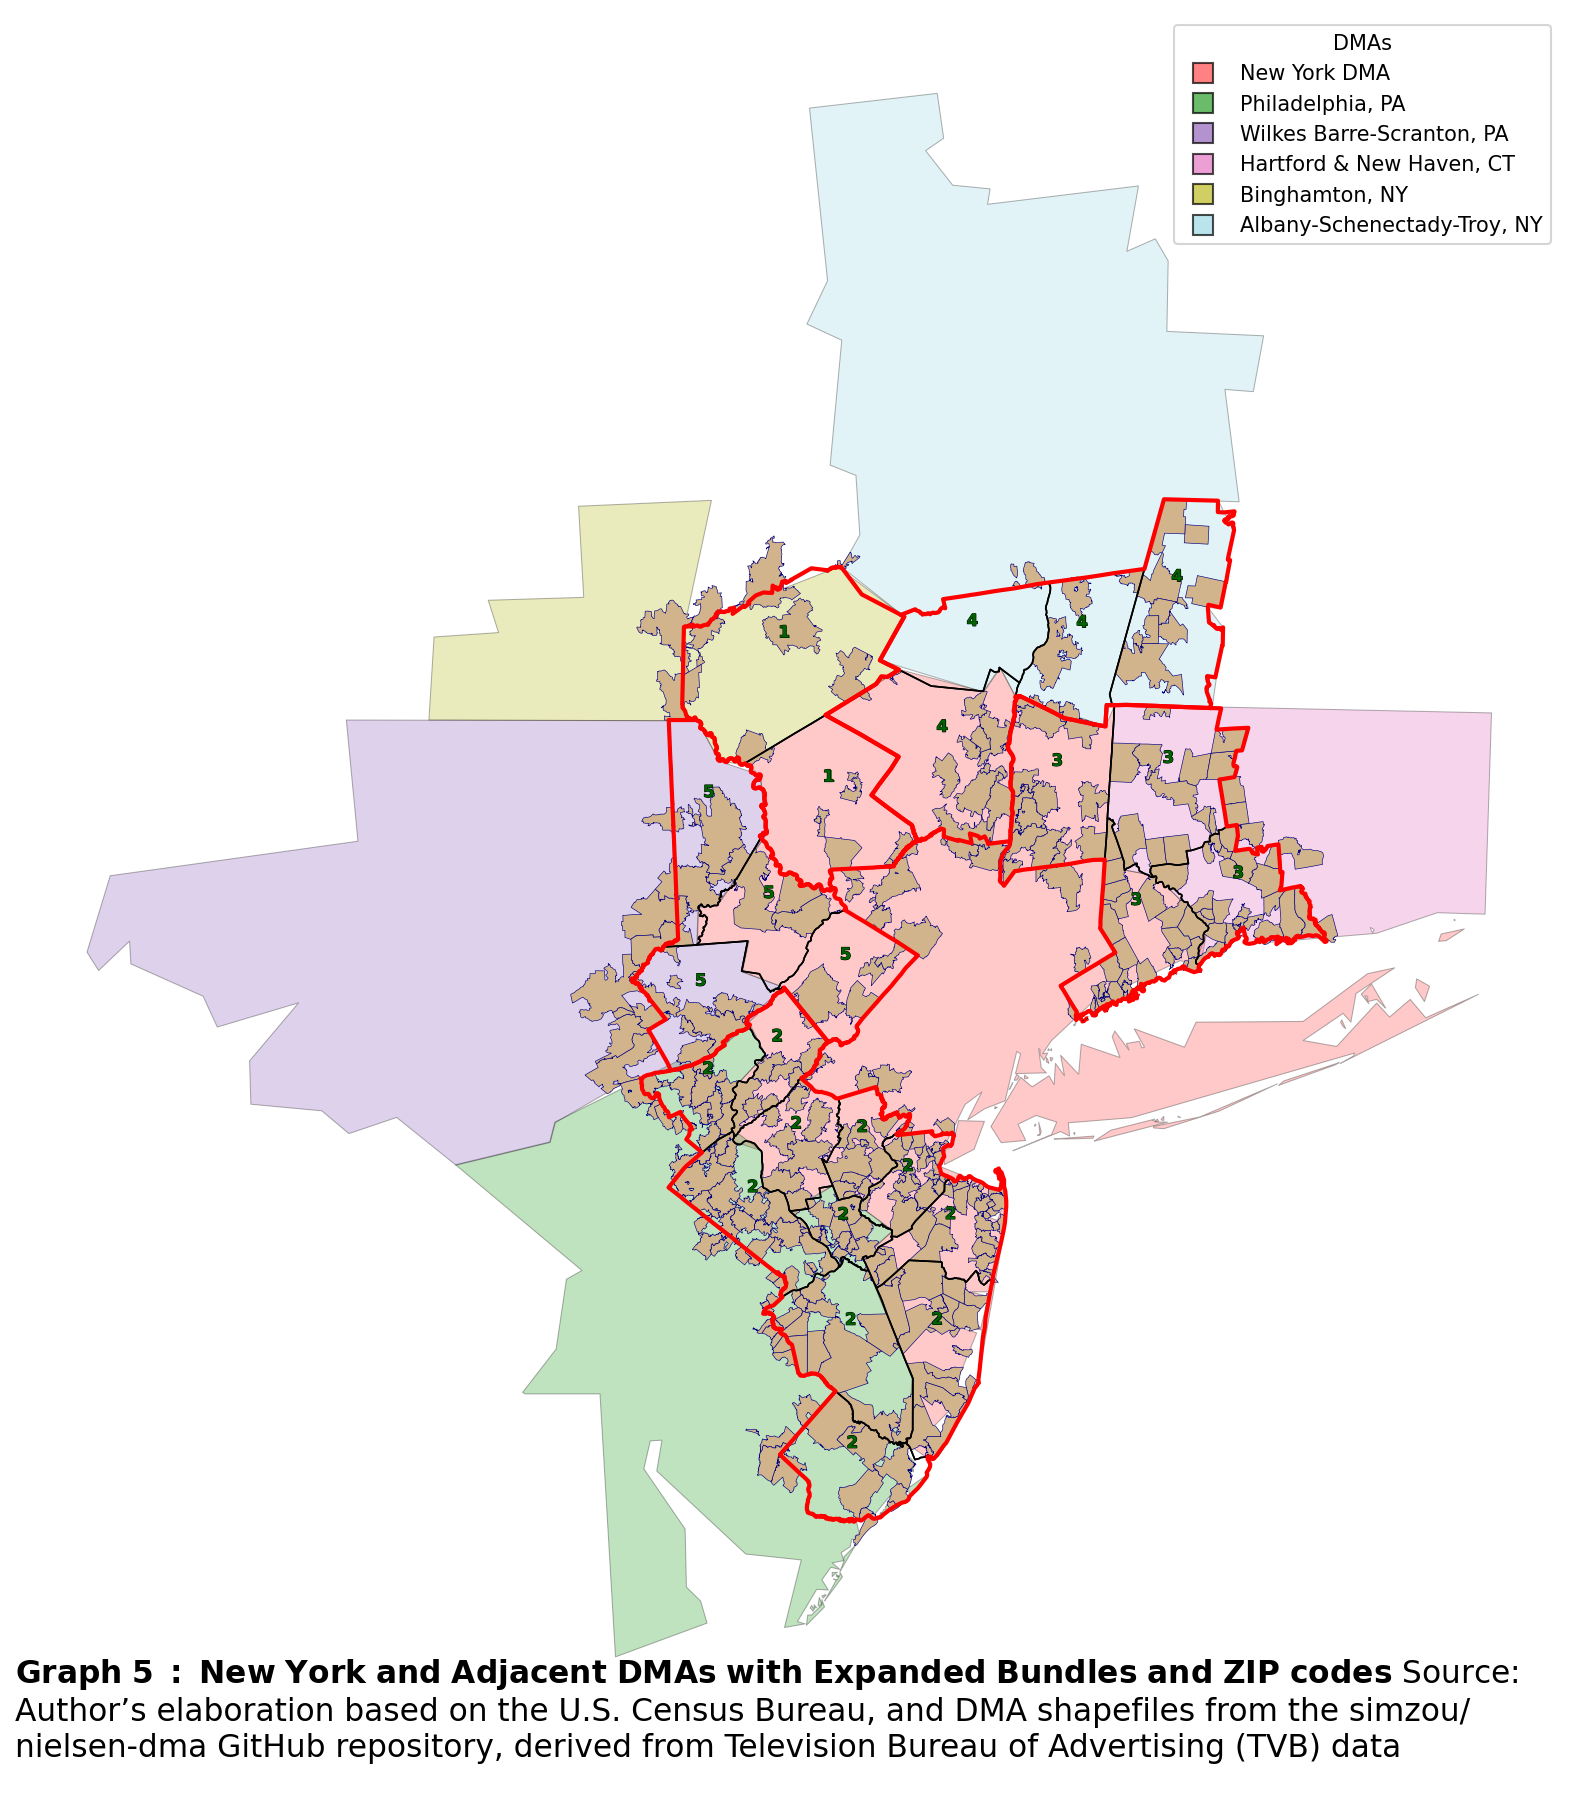

In [88]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from collections import defaultdict
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from shapely.geometry import MultiPolygon
from shapely.geometry import Point



# File paths
dma_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/DMA_data/nielsen-dma-master/nielsen_dma.json"
zip_shapefile_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/ZIP_code_coordinates_new/tl_2020_us_zcta520/tl_2020_us_zcta520.shp"
county_shapefile_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/County_coordinates_new/2018/cb_2018_us_county_500k/cb_2018_us_county_500k.shp"
zip_flags_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Analysis/ZIP_code_alternative_solution(contain_pyhon_file_with_DMA_calculation)/zip_duplicates.dta"

# Load and align CRS
dmas = gpd.read_file(dma_fp).to_crs("EPSG:4269")
zip_gdf = gpd.read_file(zip_shapefile_fp).set_crs("EPSG:4269")
county_gdf = gpd.read_file(county_shapefile_fp).to_crs("EPSG:4269")

# --- Identify adjacent DMAs and store for plotting only ---
projected_crs = "EPSG:5070"
dmas_proj = dmas.to_crs(projected_crs)
dmas_proj["geometry"] = dmas_proj["geometry"].buffer(0)
dmas_proj = dmas_proj[dmas_proj.is_valid]

ny_dma_proj = dmas_proj[dmas['dma1'].str.contains("New York", case=False, na=False)].copy()
ny_union = ny_dma_proj.unary_union

sindex = dmas_proj.sindex
adjacent_candidates = list(sindex.intersection(ny_union.buffer(0.1).bounds))
adjacent_dmas = dmas_proj.iloc[adjacent_candidates]
adjacent_dmas = adjacent_dmas[
    (adjacent_dmas.geometry.touches(ny_union) | adjacent_dmas.geometry.intersects(ny_union)) &
    (~adjacent_dmas["dma1"].str.contains("New York", case=False, na=False))
]
adjacent_dmas = adjacent_dmas.to_crs("EPSG:4269")  # for plotting only

# --- Prepare DMA coloring ---
ny_dma = dmas[dmas['dma1'].str.contains("New York", case=False, na=False)]
ny_dma["group"] = "New York DMA"
adjacent_dmas["group"] = adjacent_dmas["dma1"]
dma_combined = pd.concat([ny_dma, adjacent_dmas], ignore_index=True)

# Assign each DMA a different color
unique_names = dma_combined["group"].unique()
n_colors = len(unique_names)
color_map = cm.get_cmap('tab20', n_colors)
colors = [mcolors.to_hex(color_map(i)) for i in range(n_colors)]
name_to_color = dict(zip(unique_names, colors))

# Override New York color manually
name_to_color["New York DMA"] = "#ff4d4d"  # bright red

# Map colors
dma_combined["color"] = dma_combined["group"].map(name_to_color)
# --- ORIGINAL LOGIC STARTS HERE ---

# Load and filter ZIPs based on .dta file
zip_flags_df = pd.read_stata(zip_flags_fp)
zip_flags_df["zipcode"] = zip_flags_df["zipcode"].astype(str).str.zfill(5)

# Filter ZIPs
zip_gdf = zip_gdf[zip_gdf["ZCTA5CE20"].isin(zip_flags_df["zipcode"])]
zip_gdf = zip_gdf.to_crs("EPSG:4269")

# Project to meters for spatial calculations
ny_dma_proj = ny_dma.to_crs(projected_crs)
county_proj = county_gdf.to_crs(projected_crs)
ny_dma_proj["geometry"] = ny_dma_proj["geometry"].buffer(0)
ny_dma_union = ny_dma_proj.unary_union.buffer(0)

# 3-mile DMA buffer band
buffer_distance = 4828.03
outer = ny_dma_union.buffer(buffer_distance)
inner = ny_dma_union.buffer(-buffer_distance)
dma_band = outer.difference(inner)

# Filter counties that intersect band
band_counties = county_proj[county_proj.geometry.intersects(dma_band)].copy()
band_counties["area_total"] = band_counties.geometry.area
band_counties["area_overlap"] = band_counties.geometry.intersection(ny_dma_union).area
band_counties["pct_overlap"] = band_counties["area_overlap"] / band_counties["area_total"]

# Ensure DMAs are in same projection
dma_polygons = dmas_proj.copy()

# Initialize column
band_counties["dma_name"] = None

# Iterate over counties to assign DMA based on ≥80% area overlap
for idx, county_row in band_counties.iterrows():
    county_geom = county_row.geometry
    county_area = county_geom.area
    for _, dma_row in dma_polygons.iterrows():
        dma_geom = dma_row.geometry
        intersection_area = county_geom.intersection(dma_geom).area
        if (intersection_area / county_area) >= 0.80:
            band_counties.at[idx, "dma_name"] = dma_row["dma1"]
            break  # stop once first DMA with ≥80% match is found


# Subset
low = band_counties[band_counties["pct_overlap"] < 0.15].copy()
high = band_counties[band_counties["pct_overlap"] > 0.80].copy()

# Use spatial index for proximity filtering
high_sindex = high.sindex
proximity_threshold = 1609.34
valid_low, valid_high = set(), set()

for i, low_row in low.iterrows():
    candidates = list(high_sindex.intersection(low_row.geometry.buffer(proximity_threshold).bounds))
    for j in candidates:
        high_row = high.iloc[j]
        if low_row.geometry.distance(high_row.geometry) <= proximity_threshold:
            valid_low.add(i)
            valid_high.add(high.index[j])

# Only use proximity-filtered counties for centroid matching
filtered_low = low.loc[valid_low].copy()
filtered_high = high.loc[valid_high].copy()

# Compute centroids
filtered_low["centroid"] = filtered_low.geometry.centroid
filtered_high["centroid"] = filtered_high.geometry.centroid

# Pair each high with its closest low
pairs = []
for h_idx, h_row in filtered_high.iterrows():
    filtered_low["dist"] = filtered_low["centroid"].apply(lambda c: c.distance(h_row["centroid"]))
    closest_l_idx = filtered_low["dist"].idxmin()
    pairs.append((h_idx, closest_l_idx))

# Reproject for plotting
final_counties = pd.concat([filtered_low, filtered_high]).drop_duplicates().to_crs("EPSG:4269")

# Plot
fig, ax = plt.subplots(figsize=(12, 12), dpi=150)

# Plot each DMA in its unique color
for _, row in dma_combined.iterrows():
    row_gdf = gpd.GeoDataFrame([row], crs=dma_combined.crs)
    row_gdf.plot(
        ax=ax,
        color=row["color"],
        edgecolor='black',
        linewidth=0.5,
        alpha=0.3,
        label=row["group"]
    )

# --- Begin Modified Bundle Logic ---

# --- Begin Modified Bundle Logic ---

# Step 1: Match low counties with unique DMA to closest high counties

# Compute value counts for DMA names among low overlap counties
dma_counts_low = filtered_low["dma_name"].value_counts()

# Identify low counties with unique DMA name
unique_dma_lows = filtered_low[filtered_low["dma_name"].isin(dma_counts_low[dma_counts_low == 1].index)].copy()

# Prepare tracking
mutual_pairs = []
matched_high = set()
matched_low = set()

# Match each unique DMA low county to its closest unmatched high county
for l_idx, l_row in unique_dma_lows.iterrows():
    if pd.isnull(l_row["dma_name"]):
        continue  # skip if DMA not assigned

    # Only consider unmatched high counties
    available_high = filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()

    if not available_high.empty:
        available_high["dist"] = available_high["centroid"].apply(lambda c: c.distance(l_row["centroid"]))
        closest_h_idx = available_high["dist"].idxmin()

        # Record match
        mutual_pairs.append((closest_h_idx, l_idx))
        matched_high.add(closest_h_idx)
        matched_low.add(l_idx)

        
# Step 2: Re-match unmatched using same logic, ensuring border adjacency
unmatched_high = filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()
unmatched_low = filtered_low.loc[~filtered_low.index.isin(matched_low)].copy()

high_to_low = {}
low_to_high = {}

# Only consider unmatched pairs that touch
for h_idx, h_row in unmatched_high.iterrows():
    touching_lows = unmatched_low[unmatched_low.geometry.touches(h_row.geometry)].copy()
    if touching_lows.empty:
        continue
    touching_lows["dist"] = touching_lows["centroid"].apply(lambda c: c.distance(h_row["centroid"]))
    closest_l_idx = touching_lows["dist"].idxmin()
    high_to_low[h_idx] = closest_l_idx

for l_idx, l_row in unmatched_low.iterrows():
    touching_highs = unmatched_high[unmatched_high.geometry.touches(l_row.geometry)].copy()
    if touching_highs.empty:
        continue
    touching_highs["dist"] = touching_highs["centroid"].apply(lambda c: c.distance(l_row["centroid"]))
    closest_h_idx = touching_highs["dist"].idxmin()
    low_to_high[l_idx] = closest_h_idx

# Add second-round mutual matches
for h_idx, l_idx in high_to_low.items():
    if low_to_high.get(l_idx) == h_idx:
        if h_idx not in matched_high and l_idx not in matched_low:
            mutual_pairs.append((h_idx, l_idx))
            matched_high.add(h_idx)
            matched_low.add(l_idx)


# Step 3: Re-match remaining unmatched using same mutual closest logic with adjacency

still_unmatched_high = filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()
still_unmatched_low = filtered_low.loc[~filtered_low.index.isin(matched_low)].copy()

high_to_low = {}
low_to_high = {}

for h_idx, h_row in still_unmatched_high.iterrows():
    touching_lows = still_unmatched_low[still_unmatched_low.geometry.touches(h_row.geometry)].copy()
    if touching_lows.empty:
        continue
    touching_lows["dist"] = touching_lows["centroid"].apply(lambda c: c.distance(h_row["centroid"]))
    closest_l_idx = touching_lows["dist"].idxmin()
    high_to_low[h_idx] = closest_l_idx

for l_idx, l_row in still_unmatched_low.iterrows():
    touching_highs = still_unmatched_high[still_unmatched_high.geometry.touches(l_row.geometry)].copy()
    if touching_highs.empty:
        continue
    touching_highs["dist"] = touching_highs["centroid"].apply(lambda c: c.distance(l_row["centroid"]))
    closest_h_idx = touching_highs["dist"].idxmin()
    low_to_high[l_idx] = closest_h_idx

# Add third-round mutual matches
for h_idx, l_idx in high_to_low.items():
    if low_to_high.get(l_idx) == h_idx:
        if h_idx not in matched_high and l_idx not in matched_low:
            mutual_pairs.append((h_idx, l_idx))
            matched_high.add(h_idx)
            matched_low.add(l_idx)    

# Convert mutual pairs into bundle structure
bundles = []
county_to_bundle = {}

for h_idx, l_idx in mutual_pairs:
    bundle = {h_idx, l_idx}
    bundle_idx = len(bundles)
    bundles.append(bundle)
    county_to_bundle[h_idx] = bundle_idx
    county_to_bundle[l_idx] = bundle_idx
    
    
# Compute centroid of each bundle as centroid of the union of its counties' geometries
bundle_centroids = []
for bundle in bundles:
    geoms = band_counties.loc[list(bundle)].geometry
    # Sometimes union can be MultiPolygon, so use unary_union
    union_geom = geoms.unary_union
    centroid = union_geom.centroid
    bundle_centroids.append(centroid)
    
# Step 4: Match remaining unmatched counties by DMA & nearest bundle
still_unmatched = filtered_low.loc[~filtered_low.index.isin(matched_low)].copy()
still_unmatched = pd.concat([
    still_unmatched,
    filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()
])

# Step 5: Merge bundles that share the same set of two DMAs

# Step 5.1: Build a mapping from bundle index to DMA set
bundle_dma_sets = {}
for idx, bundle in enumerate(bundles):
    dma_set = set(band_counties.loc[list(bundle), "dma_name"])
    # Only consider bundles that consist of exactly two unique DMAs
    if len(dma_set) == 2:
        bundle_dma_sets[idx] = frozenset(dma_set)

# Step 5.2: Group bundles by identical DMA sets
dma_pair_to_bundle_idxs = defaultdict(list)
for bundle_idx, dma_pair in bundle_dma_sets.items():
    dma_pair_to_bundle_idxs[dma_pair].append(bundle_idx)

# Step 5.3: Create new merged bundles
merged_bundles = []
new_county_to_bundle = {}
seen_bundle_idxs = set()

for dma_pair, bundle_idxs in dma_pair_to_bundle_idxs.items():
    # Merge all bundles with same DMA pair
    merged_county_set = set()
    for b_idx in bundle_idxs:
        merged_county_set.update(bundles[b_idx])
        seen_bundle_idxs.add(b_idx)
    
    merged_bundles.append(merged_county_set)
    new_bundle_idx = len(merged_bundles) - 1
    for c_idx in merged_county_set:
        new_county_to_bundle[c_idx] = new_bundle_idx

# Step 5.4: Add remaining unmerged bundles
for i, bundle in enumerate(bundles):
    if i in seen_bundle_idxs:
        continue  # Already merged
    merged_bundles.append(bundle)
    new_bundle_idx = len(merged_bundles) - 1
    for c_idx in bundle:
        new_county_to_bundle[c_idx] = new_bundle_idx

# Replace original bundle structures with merged ones
bundles = merged_bundles
#county_to_bundle = new_county_to_bundle




# Loop through unmatched counties
for idx, row in still_unmatched.iterrows():
    dma_name = band_counties.loc[idx, "dma_name"]
    if pd.isnull(dma_name):
        continue  # skip if county has no DMA assigned

    # Find bundles that include at least one county with the same DMA
    candidate_bundle_idxs = []
    for b_idx, bundle in enumerate(bundles):
        bundle_dma_names = band_counties.loc[list(bundle), "dma_name"].dropna().unique()
        if dma_name in bundle_dma_names:
            candidate_bundle_idxs.append(b_idx)

    if not candidate_bundle_idxs:
        continue  # no compatible bundle found

    # Find the closest such bundle
    county_centroid = row["centroid"]
    closest_bundle_idx = None
    min_distance = float("inf")

    for b_idx in candidate_bundle_idxs:
        bundle_centroid = bundle_centroids[b_idx]
        dist = county_centroid.distance(bundle_centroid)
        if dist < min_distance:
            min_distance = dist
            closest_bundle_idx = b_idx

    # Assign county to the closest bundle
    if closest_bundle_idx is not None:
        bundles[closest_bundle_idx].add(idx)
        county_to_bundle[idx] = closest_bundle_idx

        # Recompute bundle centroid
        bundle_geom = band_counties.loc[list(bundles[closest_bundle_idx])].geometry.unary_union
        bundle_centroids[closest_bundle_idx] = bundle_geom.centroid    
    
# --- End Modified Bundle Logic ---

# Plot counties and bundles
final_counties.boundary.plot(ax=ax, color='black', linewidth=0.8, label='Counties (<15% or >80%)')
bundle_geoms = [unary_union(band_counties.loc[list(bundle)].geometry) for bundle in bundles]
bundle_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bundle_geoms), crs=band_counties.crs).to_crs("EPSG:4269")
bundle_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Bundles')

# Annotate bundle IDs
band_counties_latlon = band_counties.to_crs("EPSG:4269")
for i, bundle in enumerate(bundles, start=1):
    for idx in bundle:
        row = band_counties_latlon.loc[idx]
        centroid = row.geometry.centroid
        y_shift = row.geometry.bounds[3] - row.geometry.centroid.y
        adjusted_y = centroid.y + 0.3 * y_shift
        ax.text(centroid.x, adjusted_y, str(i), fontsize=8, fontweight='bold', color='darkgreen', ha='center', va='center')
        

        
# Build custom legend for DMAs
handles_labels = {}
for name, color in name_to_color.items():
    handles_labels[name] = plt.Line2D([0], [0], marker='s', color='w', label=name,
                                      markerfacecolor=color, markersize=10, alpha=0.7, markeredgecolor='black')
    
# Create GeoDataFrames of centroids for plotting
low_centroids = gpd.GeoDataFrame(geometry=filtered_low["centroid"], crs=filtered_low.crs).to_crs("EPSG:4269")
high_centroids = gpd.GeoDataFrame(geometry=filtered_high["centroid"], crs=filtered_high.crs).to_crs("EPSG:4269")
bundle_centroids_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bundle_centroids), crs=band_counties.crs).to_crs("EPSG:4269")

# Annotate bundle IDs with white border for better visibility
import matplotlib.patheffects as path_effects

band_counties_latlon = band_counties.to_crs("EPSG:4269")
for i, bundle in enumerate(bundles, start=1):
    for idx in bundle:
        row = band_counties_latlon.loc[idx]
        centroid = row.geometry.centroid
        y_shift = row.geometry.bounds[3] - row.geometry.centroid.y
        adjusted_y = centroid.y + 0.3 * y_shift
        txt = ax.text(
            centroid.x,
            adjusted_y,
            str(i),
            fontsize=8,
            fontweight='bold',
            color='darkgreen',
            ha='center',
            va='center'
        )
        # Add white outline to text
        txt.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='black'),
                              path_effects.Normal()])


#plt.legend(handles=list(handles_labels.values()), title="DMAs")




# --- ZIP Code enhancements ---
zip_flags_df["zipcode"] = zip_flags_df["zipcode"].astype(str).str.zfill(5)
zip_flags = zip_flags_df.set_index("zipcode")[["has0", "has1", "has2"]]
zip_gdf["zipcode"] = zip_gdf["ZCTA5CE20"].astype(str).str.zfill(5)
zip_gdf = zip_gdf.merge(zip_flags, how="left", left_on="zipcode", right_index=True)

# Filter ZIPs that intersect the counties
final_union = final_counties.unary_union
zip_gdf = zip_gdf[zip_gdf.geometry.intersects(final_union)]

# Using CSS color name
zip_gdf["fill_color"] = "tan"
zip_gdf.plot(ax=ax, color=zip_gdf["fill_color"], edgecolor='navy', linewidth=0.3, label='ZIP Codes')

# Build custom legend for DMAs
handles = []
for name, color in name_to_color.items():
    handles.append(plt.Line2D([0], [0], marker='s', color='w', label=name,
                              markerfacecolor=color, markersize=10, alpha=0.7, markeredgecolor='black'))

# ZIP codes and bundles are plotted above, now just add legend
plt.legend(handles=handles, title="DMAs", loc='upper right', fontsize=10)








plt.tight_layout()

#plt.savefig("dma_bundle_map.jpg", dpi=300, format='jpg')

# Remove axes
ax.set_axis_off()  # <-- hides all axis lines, labels, and ticks

# Add caption if desired
#fig.text(
#    0.1, 0.09,  # bottom-left corner
#    r"$\bf{Graph}$ $\bf{3}$ $\bf{:}$ $\bf{New}$ $\bf{York}$ $\bf{and}$ $\bf{Adjacent}$ $\bf{DMAs}$ $\bf{with}$ $\bf{Matched}$ $\bf{Counties}$$ "
#    "Source: Author’s elaboration based on the U.S. Census Bureau, and DMA shapefiles from the simzou/nielsen-dma GitHub repository, derived from Television Bureau of Advertising (TVB) data",
#    ha='left', fontsize=15
#)

fig.text(
    0.07, 0.0001,  # bottom-left corner
    r"$\bf{Graph}$ $\bf{5}$ $\bf{:}$ $\bf{New}$ $\bf{York}$ $\bf{and}$ $\bf{Adjacent}$ $\bf{DMAs}$ $\bf{with}$ $\bf{Expanded}$ $\bf{Bundles}$ $\bf{and}$ $\bf{ZIP}$ $\bf{codes}$ "
    "Source: \n" 
    "Author’s elaboration based on the U.S. Census Bureau, and DMA shapefiles from the simzou/\n"
    "nielsen-dma GitHub repository, derived from Television Bureau of Advertising (TVB) data\n",
    ha='left', fontsize=15
)

plt.savefig(
    "/Users/oliverraab/Desktop/CUNY/8_semester/Blog/2/ny_dma_border_counties_bundles_ZIP.png",
    dpi=300,
    bbox_inches="tight"
)


# Show the plot
plt.show()


# US Full Map

In [155]:
custom_dma_order = [
    "New York, NY",
    "Los Angeles, CA",
    "Chicago, IL",
    "Dallas-Ft. Worth, TX",
    "Philadelphia, PA",
    "Houston, TX",
    "Atlanta, GA",
    "Washington, DC (Hagerstown, MD)",
    "Boston, MA (Manchester, NH)",
    "San Francisco-Oakland-San Jose, CA",
    "Tampa-St. Petersburg (Sarasota), FL",
    "Phoenix, AZ",
    "Seattle-Tacoma, WA",
    "Detroit, MI",
    "Orlando-Daytona Beach-Melbourne, FL",
    "Minneapolis-St. Paul, MN",
    "Denver, CO",
    "Miami-Fort Lauderdale, FL",
    "Cleveland-Akron (Canton), OH",
    "Sacramento-Stockton-Modesto, CA",
    "Charlotte, NC",
    "Raleigh-Durham (Fayetteville), NC",
    "Portland, OR",
    "St. Louis, MO",
    "Indianapolis, IN",
    "Nashville, TN",
    "Pittsburgh, PA",
    "Salt Lake City, UT",
    "Baltimore, MD",
    "San Diego, CA",
    "San Antonio, TX",
    "Hartford & New Haven, CT",
    "Kansas City, MO",
    "Austin, TX",
    "Columbus, OH",
    "Greenville-Spartanburg, SC-Asheville, NC-Anderson,SC",
    "Cincinnati, OH",
    "Milwaukee, WI",
    "West Palm Beach-Ft. Pierce, FL",
    "Las Vegas, NV",
    "Jacksonville, FL",
    "Harrisburg-Lancaster-Lebanon-York, PA",
    "Grand Rapids-Kalamazoo-Battle Creek, MI",
    "Norfolk-Portsmouth-Newport News, VA",
    "Birmingham (Anniston and Tuscaloosa), AL",
    "Greensboro-High Point-Winston Salem, NC",
    "Oklahoma City, OK",
    "Albuquerque-Santa Fe, NM",
    "Louisville, KY",
    "New Orleans, LA",
    "Memphis, TN",
    "Providence, RI-New Bedford, MA",
    "Ft. Myers-Naples, FL",
    "Buffalo, NY",
    "Fresno-Visalia, CA",
    "Richmond-Petersburg, VA",
    "Mobile, AL-Pensacola (Ft. Walton Beach), FL",
    "Little Rock-Pine Bluff, AR",
    "Wilkes Barre-Scranton, PA",
    "Knoxville, TN",
    "Tulsa, OK",
    "Albany-Schenectady-Troy, NY",
    "Lexington, KY",
    "Dayton, OH",
    "Tucson (Sierra Vista), AZ",
    "Spokane, WA",
    "Des Moines-Ames, IA",
    "Green Bay-Appleton, WI",
    "Honolulu, HI",
    "Roanoke-Lynchburg, VA",
    "Wichita-Hutchinson, KS Plus",
    "Flint-Saginaw-Bay City, MI",
    "Omaha, NE",
    "Springfield, MO",
    "Huntsville-Decatur (Florence), AL",
    "Columbia, SC",
    "Madison, WI",
    "Portland-Auburn, ME",
    "Rochester, NY",
    "Harlingen-Weslaco-Brownsville-McAllen, TX",
    "Toledo, OH",
    "Charleston-Huntington, WV",
    "Waco-Temple-Bryan, TX",
    "Savannah, GA",
    "Charleston, SC",
    "Chattanooga, TN",
    "Colorado Springs-Pueblo, CO",
    "Syracuse, NY",
    "El Paso, TX",
    "Paducah, KY-Cape Girardeau, MO-Harrisburg, IL",
    "Shreveport, LA",
    "Champaign & Springfield-Decatur, IL",
    "Burlington, VT-Plattsburgh, NY",
    "Cedar Rapids-Waterloo-Iowa City & Dubuque, IA",
    "Baton Rouge, LA",
    "Ft. Smith-Fayetteville-Springdale-Rogers, AR",
    "Myrtle Beach-Florence, SC",
    "Boise, ID",
    "Jackson, MS",
    "South Bend-Elkhart, IN",
    "Tri-Cities, TN-VA",
    "Greenville-New Bern-Washington, NC",
    "Reno, NV",
    "Davenport, IA-Rock Island-Moline, IL",
    "Tallahassee, FL-Thomasville, GA",
    "Tyler-Longview(Lufkin & Nacogdoches), TX",
    "Lincoln & Hastings-Kearney, NE",
    "Augusta, GA",
    "Evansville, IN",
    "Ft. Wayne, IN",
    "Sioux Falls (Mitchell), SD",
    "Johnstown-Altoona, PA",
    "Fargo-Valley City, ND",
    "Yakima-Pasco-Richland-Kennewick, WA",
    "Springfield-Holyoke, MA",
    "Traverse City-Cadillac, MI",
    "Lansing, MI",
    "Youngstown, OH",
    "Macon, GA",
    "Eugene, OR",
    "Montgomery-Selma, AL",
    "Peoria-Bloomington, IL",
    "Santa Barbara-Santa Maria-San Luis Obispo, CA",
    "Lafayette, LA",
    "Bakersfield, CA",
    "Wilmington, NC",
    "Columbus, GA",
    "Monterey-Salinas, CA",
    "La Crosse-Eau Claire, WI",
    "Corpus Christi, TX",
    "Salisbury, MD",
    "Amarillo, TX",
    "Wausau-Rhinelander, WI",
    "Columbus-Tupelo-West Point, MS",
    "Columbia-Jefferson City, MO",
    "Chico-Redding, CA",
    "Rockford, IL",
    "Duluth, MN-Superior, WI",
    "Medford-Klamath Falls, OR",
    "Lubbock, TX",
    "Topeka, KS",
    "Monroe, LA-El Dorado, AR",
    "Beaumont-Port Arthur, TX",
    "Odessa-Midland, TX",
    "Palm Springs, CA",
    "Anchorage, AK",
    "Minot-Bismarck-Dickinson(Williston), ND",
    "Panama City, FL",
    "Sioux City, IA",
    "Wichita Falls, TX-Lawton, OK",
    "Joplin, MO-Pittsburg, KS",
    "Albany, GA",
    "Rochester, MN-Mason City, IA-Austin, MN",
    "Erie, PA",
    "Idaho Falls-Pocatello, ID",
    "Bangor, ME",
    "Gainesville, FL",
    "Biloxi-Gulfport, MS",
    "Terre Haute, IN",
    "Sherman, TX-Ada, OK",
    "Missoula, MT",
    "Binghamton, NY",
    "Wheeling, WV-Steubenville, OH",
    "Yuma, AZ-El Centro, CA",
    "Billings, MT",
    "Abilene-Sweetwater, TX",
    "Bluefield-Beckley-Oak Hill, WV",
    "Hattiesburg-Laurel, MS",
    "Rapid City, SD",
    "Dothan, AL",
    "Utica, NY",
    "Clarksburg-Weston, WV",
    "Harrisonburg, VA",
    "Jackson, TN",
    "Quincy, IL-Hannibal, MO-Keokuk, IA",
    "Charlottesville, VA",
    "Lake Charles, LA",
    "Elmira, NY",
    "Watertown, NY",
    "Bowling Green, KY",
    "Marquette, MI",
    "Jonesboro, AR",
    "Alexandria, LA",
    "Laredo, TX",
    "Butte-Bozeman, MT",
    "Bend, OR",
    "Grand Junction-Montrose, CO",
    "Twin Falls, ID",
    "Lafayette, IN",
    "Lima, OH",
    "Great Falls, MT",
    "Meridian, MS",
    "Cheyenne, WY-Scottsbluff, NE",
    "Parkersburg, WV",
    "Greenwood-Greenville, MS",
    "Eureka, CA",
    "San Angelo, TX",
    "Casper-Riverton, WY",
    "Mankato, MN",
    "Ottumwa, IA-Kirksville, MO",
    "St. Joseph, MO",
    "Fairbanks, AK",
    "Zanesville, OH",
    "Victoria, TX",
    "Helena, MT",
    "Presque Isle, ME",
    "Juneau, AK",
    "Alpena, MI",
    "North Platte, NE",
    "Glendive, MT"
]

[1/210] Processing DMA: New York, NY
[2/210] Processing DMA: Los Angeles, CA
[3/210] Processing DMA: Chicago, IL
[4/210] Processing DMA: Dallas-Ft. Worth, TX
[5/210] Processing DMA: Philadelphia, PA
[6/210] Processing DMA: Houston, TX
[7/210] Processing DMA: Atlanta, GA
[8/210] Processing DMA: Washington, DC (Hagerstown, MD)
[9/210] Processing DMA: Boston, MA (Manchester, NH)
[10/210] Processing DMA: San Francisco-Oakland-San Jose, CA
[11/210] Processing DMA: Tampa-St. Petersburg (Sarasota), FL
[12/210] Processing DMA: Phoenix, AZ
[13/210] Processing DMA: Seattle-Tacoma, WA
[14/210] Processing DMA: Detroit, MI
[15/210] Processing DMA: Orlando-Daytona Beach-Melbourne, FL
[16/210] Processing DMA: Minneapolis-St. Paul, MN
[17/210] Processing DMA: Denver, CO
[18/210] Processing DMA: Miami-Fort Lauderdale, FL
[19/210] Processing DMA: Cleveland-Akron (Canton), OH
[20/210] Processing DMA: Sacramento-Stockton-Modesto, CA
[21/210] Processing DMA: Charlotte, NC
[22/210] Processing DMA: Raleigh-D

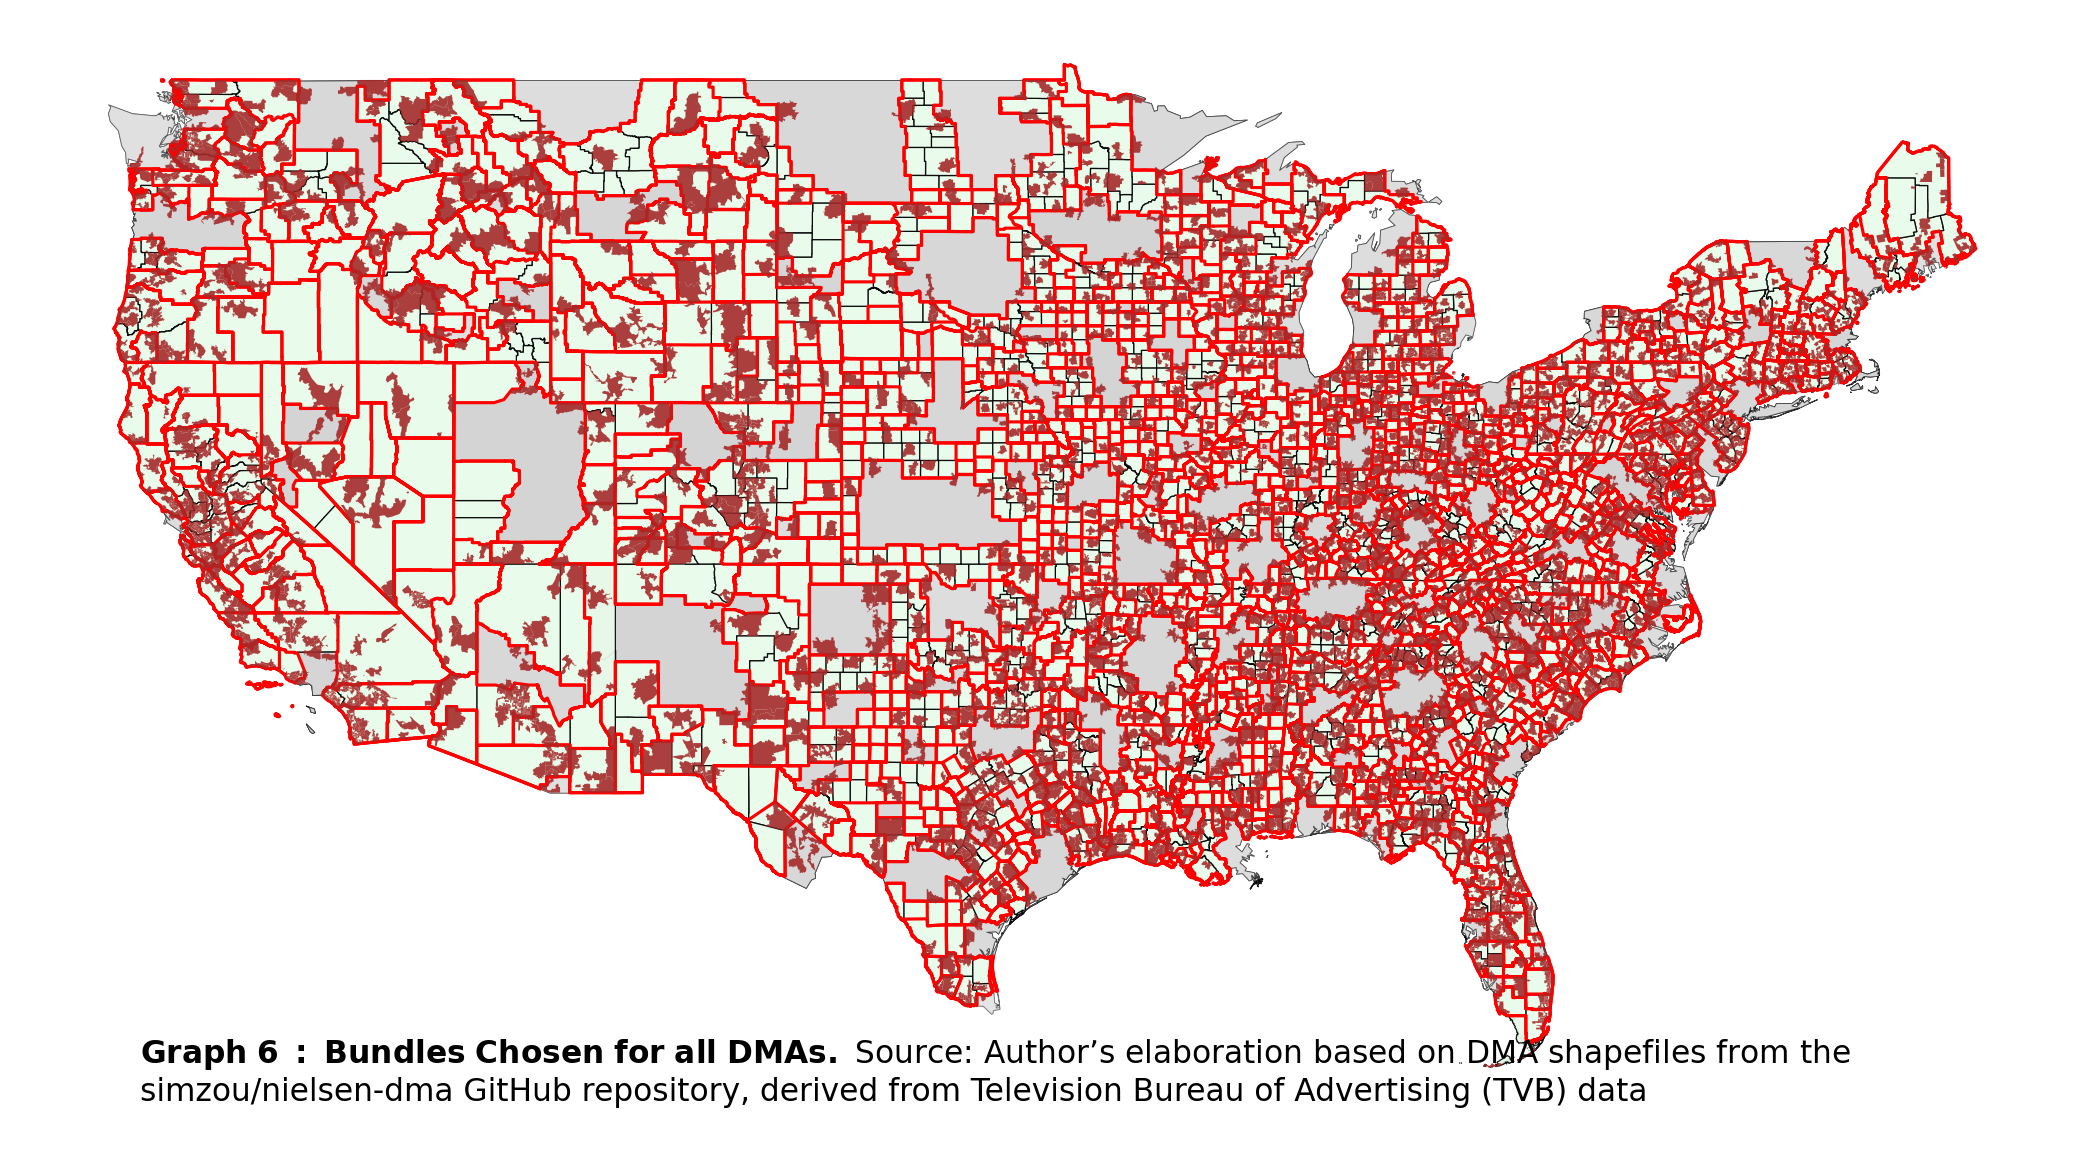

In [161]:
"""
Single-map DMA bundling script (updated)

Changes in this version:
- DMA lookup uses re.escape(...) so DMA names with parentheses/dashes match literally.
- All DMAs are forced to the same light-red color.
- ZIP polygons are drawn above bundle boundaries.
- Counties that are part of any bundle are filled with light green; bundle boundaries remain red.
"""
import os
import re
from collections import defaultdict

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import matplotlib.colors as mcolors

# -------------------------
# File paths (update as necessary)
# -------------------------
dma_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/DMA_data/nielsen-dma-master/nielsen_dma.json"
zip_shapefile_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/ZIP_code_coordinates_new/tl_2020_us_zcta520/tl_2020_us_zcta520.shp"
county_shapefile_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Data/County_coordinates_new/2018/cb_2018_us_county_500k/cb_2018_us_county_500k.shp"
zip_flags_fp = "/Users/oliverraab/Desktop/CUNY/5_semester/Short_Project3/Analysis/ZIP_code_alternative_solution(contain_pyhon_file_with_DMA_calculation)/zip_duplicates.dta"

# -------------------------
# Constants
# -------------------------
projected_crs = "EPSG:5070"
geographic_crs = "EPSG:4269"
buffer_distance = 4828.03  # ~3 miles in meters
proximity_threshold = 1609.34  # ~1 mile in meters

# -------------------------
# Load data once
# -------------------------
dmas = gpd.read_file(dma_fp).to_crs(geographic_crs)
zip_gdf = gpd.read_file(zip_shapefile_fp).set_crs(geographic_crs)
county_gdf = gpd.read_file(county_shapefile_fp).to_crs(geographic_crs)

# Preprojected DMAs for spatial computations
dmas_proj = dmas.to_crs(projected_crs)
dmas_proj["geometry"] = dmas_proj["geometry"].buffer(0)
dmas_proj = dmas_proj[dmas_proj.is_valid].copy()
dma_polygons = dmas_proj.copy()
sindex = dmas_proj.sindex

# Load ZIP flags once
zip_flags_df = pd.read_stata(zip_flags_fp)
zip_flags_df["zipcode"] = zip_flags_df["zipcode"].astype(str).str.zfill(5)
zip_flags = zip_flags_df.set_index("zipcode")[["has0", "has1", "has2"]]

# Prepare zip_gdf filtered by zip_flags set (we'll use spatial intersection later)
zip_gdf["ZCTA5CE20"] = zip_gdf["ZCTA5CE20"].astype(str).str.zfill(5)
zip_gdf = zip_gdf[zip_gdf["ZCTA5CE20"].isin(zip_flags_df["zipcode"])].copy()

# -------------------------
# Helpers
# -------------------------
def find_dma_by_name(search_name):
    """
    Match DMA rows from dmas_proj using a literal, escaped regex for the provided search_name.
    This handles parentheses, dots, dashes, etc., by escaping the string with re.escape.
    Returns a GeoDataFrame (possibly empty).
    """
    if pd.isna(search_name) or str(search_name).strip() == "":
        return gpd.GeoDataFrame(columns=dmas_proj.columns).set_crs(dmas_proj.crs)

    # Use base (portion before comma) to match, like original logic:
    base = str(search_name).split(",")[0].strip()
    if base == "":
        return gpd.GeoDataFrame(columns=dmas_proj.columns).set_crs(dmas_proj.crs)

    # Escape regex metacharacters so that parentheses, dots, etc. are matched literally
    escaped = re.escape(base)
    mask = dmas_proj["dma1"].str.contains(escaped, case=False, na=False, regex=True)
    matched = dmas_proj[mask].copy()
    return matched

# Force a single light-red color for all DMAs
name_to_color_global = {}
FORCE_DMA_COLOR = "lightgrey"  # light red for all DMAs

def get_color_for_name(name):
    """Return / register the forced light-red color for every DMA."""
    name_to_color_global[name] = FORCE_DMA_COLOR
    return FORCE_DMA_COLOR

# -------------------------
# Prepare the single figure
# -------------------------
fig, ax = plt.subplots(figsize=(14, 10), dpi=150)

# Containers to collect geometries/GeoDataFrames across DMAs for combined plotting
all_dma_rows = []            # list of dict rows (for DMA polygons plotting and legend)
final_counties_list = []     # list of GeoDataFrames (final counties per DMA in geographic_crs)
bundle_geoms_all = []        # list of shapely geometries (bundle unions in geographic_crs)

# -------------------------
# Main loop: iterate through DMAs and append results to containers/ax
# -------------------------
for i_dma, dma_full_name in enumerate(custom_dma_order, start=1):
    print(f"[{i_dma}/{len(custom_dma_order)}] Processing DMA: {dma_full_name}")

    target_dma_proj = find_dma_by_name(dma_full_name)
    if target_dma_proj.empty:
        print(f"  WARNING: DMA '{dma_full_name}' not found. Skipping.")
        continue

    target_union = target_dma_proj.unary_union.buffer(0)

    # Find adjacent DMAs (projected) for plotting
    adjacent_candidates = list(sindex.intersection(target_union.buffer(0.1).bounds))
    adjacent_dmas = dmas_proj.iloc[adjacent_candidates].copy()
    # exclude the main target's base name from adjacent list
    base_name = target_dma_proj.iloc[0]["dma1"].split(",")[0]
    adjacent_dmas = adjacent_dmas[
        (adjacent_dmas.geometry.touches(target_union) | adjacent_dmas.geometry.intersects(target_union)) &
        (~adjacent_dmas["dma1"].str.contains(re.escape(base_name), case=False, na=False, regex=True))
    ].copy()

    # Combine target (labeled with full requested name) + adjacent (use their dma1 names) in geographic CRS for plotting
    target_dma_latlon = target_dma_proj.to_crs(geographic_crs).copy()
    target_dma_latlon["group"] = dma_full_name
    adjacent_dmas_latlon = adjacent_dmas.to_crs(geographic_crs).copy()
    adjacent_dmas_latlon["group"] = adjacent_dmas_latlon["dma1"]
    dma_combined = pd.concat([target_dma_latlon, adjacent_dmas_latlon], ignore_index=True)

    # register colors (force same color for all DMAs)
    for name in dma_combined["group"].unique():
        get_color_for_name(name)

    # Append DMA rows for later plotting (store as dict so it's easy to construct GeoDF slice later)
    for _, row in dma_combined.iterrows():
        all_dma_rows.append({
            "geometry": row.geometry,
            "group": row["group"],
            "color": name_to_color_global[row["group"]],
            "dma1": row.get("dma1", None)
        })

    # -------------------------
    # Follow the same bundling logic but accumulate results (no immediate showing)
    # -------------------------
    # Prepare iteration-specific data
    target_dma_proj_iter = target_dma_proj.to_crs(projected_crs).copy()
    county_proj = county_gdf.to_crs(projected_crs).copy()
    target_dma_proj_iter["geometry"] = target_dma_proj_iter["geometry"].buffer(0)
    target_dma_union = target_dma_proj_iter.unary_union.buffer(0)

    # 3-mile buffer band
    outer = target_dma_union.buffer(buffer_distance)
    inner = target_dma_union.buffer(-buffer_distance)
    dma_band = outer.difference(inner)

    band_counties = county_proj[county_proj.geometry.intersects(dma_band)].copy()
    if band_counties.empty:
        print(f"  No counties intersect the buffer band for '{dma_full_name}'. Skipping bundling for this DMA.")
        continue

    band_counties["area_total"] = band_counties.geometry.area
    band_counties["area_overlap"] = band_counties.geometry.intersection(target_dma_union).area
    band_counties["pct_overlap"] = band_counties["area_overlap"] / band_counties["area_total"]
    band_counties["dma_name"] = None

    # Assign county dma_name if >=80% within any DMA (vectorizing would be better but keep original loop)
    for c_idx, county_row in band_counties.iterrows():
        county_geom = county_row.geometry
        county_area = county_geom.area
        assigned = False
        for _, dma_row in dma_polygons.iterrows():
            intersection_area = county_geom.intersection(dma_row.geometry).area
            if county_area > 0 and (intersection_area / county_area) >= 0.80:
                band_counties.at[c_idx, "dma_name"] = dma_row["dma1"]
                assigned = True
                break
        if not assigned:
            band_counties.at[c_idx, "dma_name"] = None

    # low and high subsets by pct_overlap
    low = band_counties[band_counties["pct_overlap"] < 0.15].copy()
    high = band_counties[band_counties["pct_overlap"] > 0.80].copy()

    if low.empty or high.empty:
        print(f"  Not enough low/high counties for DMA '{dma_full_name}'. Skipping.")
        continue

    # proximity filtering
    high_sindex = high.sindex
    valid_low, valid_high = set(), set()
    for i_low, low_row in low.iterrows():
        candidates = list(high_sindex.intersection(low_row.geometry.buffer(proximity_threshold).bounds))
        for jpos in candidates:
            try:
                high_row = high.iloc[jpos]
            except Exception:
                continue
            if low_row.geometry.distance(high_row.geometry) <= proximity_threshold:
                valid_low.add(i_low)
                valid_high.add(high.index[jpos])

    filtered_low = low.loc[valid_low].copy()
    filtered_high = high.loc[valid_high].copy()
    if filtered_low.empty or filtered_high.empty:
        print(f"  After proximity filter, no filtered pairs remain for '{dma_full_name}'. Skipping.")
        continue

    # centroids in projected CRS
    filtered_low["centroid"] = filtered_low.geometry.centroid
    filtered_high["centroid"] = filtered_high.geometry.centroid

    # initial pairing logic (unique low DMA first)
    dma_counts_low = filtered_low["dma_name"].value_counts()
    unique_dma_lows = filtered_low[filtered_low["dma_name"].isin(dma_counts_low[dma_counts_low == 1].index)].copy()

    mutual_pairs = []
    matched_high = set()
    matched_low = set()

    # Round 1
    for l_idx, l_row in unique_dma_lows.iterrows():
        if pd.isnull(l_row["dma_name"]):
            continue
        available_high = filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()
        if available_high.empty:
            continue
        dists = available_high["centroid"].apply(lambda c: c.distance(l_row["centroid"]))
        closest_h_idx = dists.idxmin()
        mutual_pairs.append((closest_h_idx, l_idx))
        matched_high.add(closest_h_idx)
        matched_low.add(l_idx)

    # adjacency mutual rounds helper
    def adjacency_mutual_round(high_df, low_df, matched_high_set, matched_low_set):
        high_to_low = {}
        low_to_high = {}
        new_pairs = []
        for h_idx, h_row in high_df.iterrows():
            if h_idx in matched_high_set:
                continue
            touching_lows = low_df[low_df.geometry.touches(h_row.geometry)].copy()
            if touching_lows.empty:
                continue
            touching_lows["dist"] = touching_lows["centroid"].apply(lambda c: c.distance(h_row["centroid"]))
            closest_l_idx = touching_lows["dist"].idxmin()
            high_to_low[h_idx] = closest_l_idx
        for l_idx, l_row in low_df.iterrows():
            if l_idx in matched_low_set:
                continue
            touching_highs = high_df[high_df.geometry.touches(l_row.geometry)].copy()
            if touching_highs.empty:
                continue
            touching_highs["dist"] = touching_highs["centroid"].apply(lambda c: c.distance(l_row["centroid"]))
            closest_h_idx = touching_highs["dist"].idxmin()
            low_to_high[l_idx] = closest_h_idx
        for h_idx, l_idx in high_to_low.items():
            if low_to_high.get(l_idx) == h_idx:
                if h_idx not in matched_high_set and l_idx not in matched_low_set:
                    new_pairs.append((h_idx, l_idx))
                    matched_high_set.add(h_idx)
                    matched_low_set.add(l_idx)
        return new_pairs

    # Round 2 & 3
    unmatched_high = filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()
    unmatched_low = filtered_low.loc[~filtered_low.index.isin(matched_low)].copy()
    mutual_pairs += adjacency_mutual_round(unmatched_high, unmatched_low, matched_high, matched_low)

    still_unmatched_high = filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()
    still_unmatched_low = filtered_low.loc[~filtered_low.index.isin(matched_low)].copy()
    mutual_pairs += adjacency_mutual_round(still_unmatched_high, still_unmatched_low, matched_high, matched_low)

    # Build bundles
    bundles = []
    county_to_bundle = {}
    for h_idx, l_idx in mutual_pairs:
        bundle = {h_idx, l_idx}
        bundle_idx = len(bundles)
        bundles.append(bundle)
        county_to_bundle[h_idx] = bundle_idx
        county_to_bundle[l_idx] = bundle_idx

    # initial bundle centroids (projected)
    bundle_centroids = []
    for bundle in bundles:
        geoms = band_counties.loc[list(bundle)].geometry
        union_geom = geoms.unary_union
        bundle_centroids.append(union_geom.centroid)

    # Step 4: remaining unmatched
    still_unmatched = filtered_low.loc[~filtered_low.index.isin(matched_low)].copy()
    still_unmatched = pd.concat([
        still_unmatched,
        filtered_high.loc[~filtered_high.index.isin(matched_high)].copy()
    ])

    # Step 5: merge bundles that share same two DMAs
    bundle_dma_sets = {}
    for b_idx, bundle in enumerate(bundles):
        dma_set = set(band_counties.loc[list(bundle), "dma_name"])
        if len(dma_set) == 2:
            bundle_dma_sets[b_idx] = frozenset(dma_set)

    dma_pair_to_bundle_idxs = defaultdict(list)
    for bundle_idx, dma_pair in bundle_dma_sets.items():
        dma_pair_to_bundle_idxs[dma_pair].append(bundle_idx)

    merged_bundles = []
    new_county_to_bundle = {}
    seen_bundle_idxs = set()

    for dma_pair, bundle_idxs in dma_pair_to_bundle_idxs.items():
        merged_county_set = set()
        for b_idx in bundle_idxs:
            merged_county_set.update(bundles[b_idx])
            seen_bundle_idxs.add(b_idx)
        merged_bundles.append(merged_county_set)
        new_bundle_idx = len(merged_bundles) - 1
        for c_idx in merged_county_set:
            new_county_to_bundle[c_idx] = new_bundle_idx

    # add remaining unmerged bundles
    for i_b, bundle in enumerate(bundles):
        if i_b in seen_bundle_idxs:
            continue
        merged_bundles.append(set(bundle))
        new_bundle_idx = len(merged_bundles) - 1
        for c_idx in bundle:
            new_county_to_bundle[c_idx] = new_bundle_idx

    bundles = merged_bundles
    county_to_bundle = new_county_to_bundle

    # recompute bundle centroids for merged bundles (projected)
    bundle_centroids = []
    for b_idx, bundle in enumerate(bundles):
        if not bundle:
            bundle_centroids.append(None)
            continue
        union_geom = band_counties.loc[list(bundle)].geometry.unary_union
        bundle_centroids.append(union_geom.centroid)

    # assign remaining unmatched counties to nearest compatible bundle by DMA
    for c_idx, row in still_unmatched.iterrows():
        dma_name = band_counties.loc[c_idx, "dma_name"]
        if pd.isnull(dma_name):
            continue
        candidate_bundle_idxs = []
        for b_idx, bundle in enumerate(bundles):
            bundle_dma_names = band_counties.loc[list(bundle), "dma_name"].dropna().unique()
            if dma_name in bundle_dma_names:
                candidate_bundle_idxs.append(b_idx)
        if not candidate_bundle_idxs:
            continue
        county_centroid = row["centroid"]
        closest_bundle_idx = None
        min_distance = float("inf")
        for b_idx in candidate_bundle_idxs:
            bc = bundle_centroids[b_idx]
            if bc is None:
                continue
            dist = county_centroid.distance(bc)
            if dist < min_distance:
                min_distance = dist
                closest_bundle_idx = b_idx
        if closest_bundle_idx is not None:
            bundles[closest_bundle_idx].add(c_idx)
            county_to_bundle[c_idx] = closest_bundle_idx
            union_geom = band_counties.loc[list(bundles[closest_bundle_idx])].geometry.unary_union
            bundle_centroids[closest_bundle_idx] = union_geom.centroid

    # Collect final_counties for this DMA (in geographic_crs for plotting later)
    final_counties = pd.concat([filtered_low, filtered_high]).drop_duplicates().to_crs(geographic_crs)
    final_counties_list.append(final_counties)

    # Build bundle geometries (reprojected to geographic_crs) and collect them
    for bundle in bundles:
        if not bundle:
            continue
        union_geom_proj = band_counties.loc[list(bundle)].geometry.unary_union
        # convert to geographic_crs via GeoSeries conversion
        geo = gpd.GeoSeries([union_geom_proj], crs=projected_crs).to_crs(geographic_crs).iloc[0]
        bundle_geoms_all.append(geo)

# -------------------------
# After loop: plot combined results on the single Ax
# -------------------------
# DMA polygons (use GeoDataFrame constructed from all_dma_rows)
if all_dma_rows:
    dma_df = gpd.GeoDataFrame(all_dma_rows, geometry=[r["geometry"] for r in all_dma_rows], crs=geographic_crs)
    # Plot each DMA polygon row-by-row so colors are respected (all will be light red)
    for _, row in dma_df.iterrows():
        gpd.GeoDataFrame([row], geometry=[row.geometry], crs=geographic_crs).plot(
            ax=ax, color=row["color"], edgecolor='black', linewidth=0.4, alpha=0.25, zorder=1
        )

# final counties (combined)
combined_final_counties = None
if final_counties_list:
    combined_final_counties = pd.concat(final_counties_list).drop_duplicates().copy()
    # Plot non-bundled county boundaries first (zorder lower than bundled fills)
    # We'll determine bundled counties below and fill them
    #combined_final_counties.boundary.plot(ax=ax, color='black', linewidth=0.6, label='Counties (<15% or >80%)', zorder=2)

# bundles (combined) geometries (kept but boundaries will be drawn after filling bundled counties)
bundle_gdf = None
if bundle_geoms_all:
    bundle_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bundle_geoms_all), crs=geographic_crs)

# Determine which counties are part of any bundle and fill them light green
if combined_final_counties is not None and bundle_geoms_all:
    # union of all bundle geometries (geographic_crs)
    bundles_union = unary_union(bundle_geoms_all)
    # Select counties that intersect the union (these are counties that are in a bundle)
    bundled_counties = combined_final_counties[combined_final_counties.geometry.intersects(bundles_union)].copy()
    non_bundled_counties = combined_final_counties[~combined_final_counties.index.isin(bundled_counties.index)].copy()

    # Plot non-bundled county boundaries (already plotted above via boundary, but ensure zorder)
    if not non_bundled_counties.empty:
        non_bundled_counties.boundary.plot(ax=ax, color='black', linewidth=0.6, zorder=2)

    # Fill bundled counties with light green (above county boundaries, below bundle borders)
    if not bundled_counties.empty:
        bundled_counties.plot(ax=ax, color='#eafcec', edgecolor='black', linewidth=0.6, zorder=1.5, alpha=0.9)

# Now draw bundle boundaries on top so red borders remain visible
if bundle_gdf is not None and not bundle_gdf.empty:
    bundle_gdf.boundary.plot(ax=ax, color='red', linewidth=1.5, label='Bundles', zorder=5)

# ZIP codes: intersection with union of all final_counties
if final_counties_list:
    union_all = unary_union([g.unary_union for g in final_counties_list])
    zip_gdf_plot = zip_gdf[zip_gdf.geometry.intersects(union_all)].copy()
    if not zip_gdf_plot.empty:
        zip_gdf_plot["fill_color"] = "brown"
        # Plot ZIPs above bundles by giving a higher zorder
        zip_gdf_plot.plot(ax=ax, color=zip_gdf_plot["fill_color"],
                          alpha=0.9, label='ZIP Codes', zorder=6)

# Build legend for DMAs using global mapping (all DMAs same color)
handles = []
# Show one DMA color swatch (they are all the same)
handles.append(plt.Line2D([0], [0], marker='s', color='w', label='DMAs', markerfacecolor=FORCE_DMA_COLOR,
                          markersize=10, alpha=0.7, markeredgecolor='black'))
# Add county, bundle and ZIP handles
handles.append(plt.Line2D([0], [0], color='black', lw=1, label='Counties (<15% or >80%)'))
handles.append(plt.Line2D([0], [0], color='red', lw=2, label='Bundles'))
handles.append(plt.Line2D([0], [0], marker='s', color='w', label='Bundled counties', markerfacecolor='lightgreen',
                          markersize=10, markeredgecolor='black'))
handles.append(plt.Line2D([0], [0], marker='s', color='w', label='ZIP Codes',
                          markerfacecolor='tan', markersize=10, markeredgecolor='navy'))

#plt.legend(handles=handles, title="Map Layers", loc='upper right', fontsize=9)

ax.set_axis_off()
plt.tight_layout()

# Place caption inside the figure, but in the extra space below axes
fig.text(
    0.07, 0.12,  # x = left, y = in the space below axes
    r"$\bf{Graph}$ $\bf{6}$ $\bf{:}$ $\bf{Bundles}$ $\bf{Chosen}$ $\bf{for}$ $\bf{all}$ $\bf{DMAs.}$ "
    "Source: Author’s elaboration based on DMA shapefiles from the\n" 
    "simzou/nielsen-dma GitHub repository, derived from Television Bureau of Advertising (TVB) data\n",
    ha='left', fontsize=15
)


# --------------------------------------------------
# Save
# --------------------------------------------------
plt.savefig(
    "/Users/oliverraab/Desktop/CUNY/8_semester/Blog/2/all_bundles_ZIP2.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()